In [1]:
from transformers import AutoModel,AutoTokenizer
import torch
auto_model = AutoModel.from_pretrained("bert-base-cased",output_hidden_states=True)



print(f"\nmodel class is      : {type(auto_model)}")


tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
print(f"\nmodel class is      : {type(tokenizer)}")


torch.save(auto_model,"hw2/stud/saved/bert.pth")



/home/mv/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be ex


model class is      : <class 'transformers.models.bert.modeling_bert.BertModel'>

model class is      : <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


## Bert and Tokenizer for English

In [2]:
import os
import json
import logging
import torch
from torch.utils.data import DataLoader,Dataset
import random
from typing import Dict

class SRL(Dataset):
 
    def __init__(self,language,tokenizer,path,args_roles = None,pos_list = None,predicate_dis = None) -> None:
        #train
        #self.path_root = 'data'
        #inference 
        self.path_root = 'hw2/stud/data'
        #self.path_root = 'stud/data'
        self.load_data(language,path)
        if args_roles is None :
            self.args_roles,self.list_broken_id = self.list_arg_roles()
            self.args_roles.append("UNK")
        else : 
            self.args_roles = args_roles
            _,self.list_broken_id = self.list_arg_roles()
        

        if pos_list is None :
            self.pos_list,_ = self.list_pos()
            self.pos_list.append("Nothing")
            self.pos_list.append("UNK")
        else : 
            self.pos_list = pos_list
        


        if predicate_dis is None :
            self.predicate_dis,_ = self.list_predicate_roles()
            self.predicate_dis.append("Nothing")
            self.predicate_dis.append("UNK")
        else : 
            self.predicate_dis = predicate_dis
        
        
        


        self.tokenizer = tokenizer

    def load_data(self,language,mode):
        
        mode = mode+".json"
        path = os.path.join(self.path_root,language,mode)
        data_file = open(path)
       
        data_ = json.load(data_file)

        list_data = []

        for data in data_:
            list_data.append(data_[data])
        

        self.data = list_data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, id : int):

        flag = False
        if id in self.list_broken_id :
            flag = True
            while flag == True:

                rand_id = random.randint(0, len(self.data)-1)
                
                if rand_id in self.list_broken_id :
                    pass
                else :
                    flag = False
                    id = rand_id        


        data = self.pre_processing(self.data[id])
        data = self.processig(data)
        return data
        
    def pre_processing(self, data:dict):
        data_list = []
        for role in data["roles"]:
            dictionary = dict()
            dictionary["words"] = data["words"]
            dictionary["role"] = data["roles"][role]
            dictionary["pre_idx"] = role
            dictionary["pos_tags"] = data["pos_tags"]
            dictionary["predicate_meaning"] = data["predicates"]
            data_list.append(dictionary)    
        return data_list
    
    def processig(self,data_list:list):
        
        for dictionary in data_list:

            #dictionary["words"] = data["words"]
            dictionary["gt_arg_identification"] = self.arg_id(dictionary["role"])
            dictionary["gt_arg_classification"] = self.arg_class(dictionary["role"])
            dictionary["pos_idx"] = self.pos_idx(dictionary["pos_tags"])
            dictionary["predicate_meaning_idx"] = self.predicate_meaning_idx(dictionary["predicate_meaning"])
        
        return data_list
   
    def list_arg_roles(self):
        list_roles = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : roles = element["roles"]
            except : flag = False
            if flag :
                for e in roles:
                    sentence = element["roles"][e]

                    for word in sentence:
                        
                        list_roles.append(word)
                list_roles = list(set(list_roles))
            else : 
                list_broken_id.append(i)
        return list_roles,list_broken_id

    def list_predicate_roles(self):
        list_predicate_roles = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : predicates = element["predicates"]
            except : flag = False
            if flag :
                for pre in predicates:
                    list_predicate_roles.append(pre)
                list_predicate_roles = list(set(list_predicate_roles))
            else : 
                list_broken_id.append(i)
        return list_predicate_roles,list_broken_id

    def list_pos(self):
        list_pos = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : pos = element["pos_tags"]
            except : flag = False
            if flag :
                for e in pos:
                    list_pos.append(e)
                list_pos = list(set(list_pos))
            else : 
                list_broken_id.append(i)
        return list_pos,list_broken_id
  
    def arg_class(self,role:list):
        list_idxs = []
        for element in role:
            try : list_idxs.append(self.args_roles.index(element))
            except : list_idxs.append(self.args_roles.index("UNK"))
        

        return torch.tensor(list_idxs, dtype=torch.int64)

    def arg_id(self,role:dict):
        list_idxs = []
        for element in role:
            if element == "_":
                list_idxs.append(0)
            else :
                list_idxs.append(1)

        

        return torch.tensor(list_idxs, dtype=torch.int64)

    def pos_idx(self,pos_tags:dict):
        list_idxs = []
        list_idxs.append(self.pos_list.index("Nothing"))

        for element in pos_tags:
            try :list_idxs.append(self.pos_list.index(element))
            except :list_idxs.append(self.pos_list.index("UNK"))
        
        list_idxs.append(self.pos_list.index("Nothing"))
        return torch.tensor(list_idxs, dtype=torch.int64)
    
    def predicate_meaning_idx(self,predicate_meaning_tags:dict):
        list_idxs = []
        list_idxs.append(self.predicate_dis.index("Nothing"))

        for element in predicate_meaning_tags:
            try : list_idxs.append(self.predicate_dis.index(element))
            except : list_idxs.append(self.predicate_dis.index("UNK"))
            
        
        list_idxs.append(self.predicate_dis.index("Nothing"))
        return torch.tensor(list_idxs, dtype=torch.int64)
   
    def role_gen(self,sentence):

        base = ["_"]*len(sentence["predicates"])
        roles_dict = dict()
        counter = 0
        for i,item in enumerate(sentence["predicates"]):

            if item != "_":
                base = ["_"]*len(sentence["predicates"])
                sentence["roles"] = 10
                roles_dict[str(i)] = base
                counter += 1
        
        if counter == 0:
            sentence["roles"] = { }
            flag = False
            
                
        else :
            sentence["roles"] = roles_dict
            flag = True

        return sentence,flag
        
    def prepare_batch(self,sentence):

        sentence,flag = self.role_gen(sentence)
        
        if flag :

            data = self.pre_processing(sentence)
            data = self.processig(data)
            data = [data]
            
            
            input = dict() 
            gt = dict()
            batch_sentence = [] 
            
            for period in data:
                for sentence in period :

                    
                
                    #print(len(sentence[0]["words"]))
                    pre_idx = int(sentence["pre_idx"])
                    

                    predicate = sentence["words"][pre_idx]

                    text = " ".join(sentence["words"])
                    tokens: list[str] = text.split()
                    predicate: list[str] = predicate.split()

                    #text = sentence[0]["words"]
                    
                    t = (tokens,predicate)

                    batch_sentence.append(t)
                
                
            
        
        

            batch_output = self.tokenizer.batch_encode_plus(batch_sentence,padding=True,is_split_into_words=True, truncation=True,return_offsets_mapping=True, return_tensors="pt")
            


            for period in data:

                list_positional_predicate_encoding = []
                list_predicate_index = [] 
                list_pos_index = [] 
                list_arg_gt = []
                list_predicate_meaning_index = []
                list_meaning_predicate_encoding = []

                for sentence in period:
                    #positional_encoding
                    #+2 per il CLS iniziale ad SEP finale
                    sentence_words_lenght =  len(sentence["words"])
                    positional_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
                    #+1 per il CLS iniziale
                    pre_idx = int(sentence["pre_idx"])
                    positional_predicate_encoding[:,pre_idx+1] = 1
                    list_positional_predicate_encoding.append(positional_predicate_encoding)
                    #print("positional_prefix_encoding",positional_predicate_encoding)
                    list_predicate_index.append(pre_idx)

                    meaning_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
                    pre_idx = int(sentence["pre_idx"])
                    #rather then set the flag 0,1 set with class verb
                    meaning_predicate_encoding[:,pre_idx+1] = sentence["predicate_meaning_idx"][pre_idx+1]
                    list_meaning_predicate_encoding.append(meaning_predicate_encoding)
                    

                    pos = torch.unsqueeze(sentence["pos_idx"],dim = 0)
                    list_pos_index.append(pos)
                    predicate_meaning_idxs = torch.unsqueeze(sentence["predicate_meaning_idx"],dim = 0)
                    list_predicate_meaning_index.append(predicate_meaning_idxs)


                    arg_gt = torch.unsqueeze(sentence["gt_arg_classification"],dim = 0)
                    list_arg_gt.append(arg_gt)


            list_arg_gt = torch.cat(list_arg_gt,dim = 0)
            list_pos_index = torch.cat(list_pos_index,dim = 0)
            list_predicate_meaning_index = torch.cat(list_predicate_meaning_index,dim = 0)
            list_positional_predicate_encoding = torch.cat(list_positional_predicate_encoding,dim = 0)
            list_predicate_meaning_index_bis = torch.cat(list_meaning_predicate_encoding,dim = 0)
            gt["arg_gt"] = list_arg_gt
            input["predicate_index"] = list_predicate_index
            input["pos_index"] = list_pos_index.long()
            input["predicate_meaning_idx"] = list_predicate_meaning_index.long()
            input["predicate_meaning_idx_bis"] = list_predicate_meaning_index_bis.long()
            offset = batch_output.pop("offset_mapping")
            input["BERT_input"] = batch_output
            input["positional_encoding"] = list_positional_predicate_encoding.long()
            input["offset_mapping"] = offset
            input["gt"] = gt
        
        else :
            input = sentence






        return input,flag
    
# here we define our collate function
def collate_fn(batch) -> Dict[str, torch.Tensor]:
    #print(batch)
    input = dict() 
    batch_sentence = [] 
    #print(len(batch))
    for period in batch:
        for sentence in period :
        
            #print(len(sentence[0]["words"]))
            pre_idx = int(sentence["pre_idx"])
            

            predicate = sentence["words"][pre_idx]

            text = " ".join(sentence["words"])
            tokens: list[str] = text.split()
            predicate: list[str] = predicate.split()

            #text = sentence[0]["words"]
            
            t = (tokens,predicate)

            batch_sentence.append(t)
            #print(batch_sentence)

    batch_output = tokenizer.batch_encode_plus(batch_sentence,padding=True,is_split_into_words=True, truncation=True,return_offsets_mapping=True, return_tensors="pt")
    #print(batch_output.keys())


    gt = dict()
    
    


    for period in batch:

        list_positional_predicate_encoding = []
        list_arg_gt = []
        list_predicate_index = [] 
        list_pos_index = [] 
        list_predicate_meaning_index = []
        list_meaning_predicate_encoding = []

        for sentence in period:
            #positional_encoding
            #+2 per il CLS iniziale ad SEP finale
            sentence_words_lenght =  len(sentence["words"])
            positional_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
            #+1 per il CLS iniziale
            pre_idx = int(sentence["pre_idx"])
            positional_predicate_encoding[:,pre_idx+1] = 1
            list_positional_predicate_encoding.append(positional_predicate_encoding)
            #print("positional_prefix_encoding",positional_predicate_encoding)
            list_predicate_index.append(pre_idx)


            meaning_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
            pre_idx = int(sentence["pre_idx"])
            #rather then set the flag 0,1 set with class verb
            meaning_predicate_encoding[:,pre_idx+1] = sentence["predicate_meaning_idx"][pre_idx+1]
            list_meaning_predicate_encoding.append(meaning_predicate_encoding)




            pos = torch.unsqueeze(sentence["pos_idx"],dim = 0)
            list_pos_index.append(pos)
            predicate_meaning_idxs = torch.unsqueeze(sentence["predicate_meaning_idx"],dim = 0)
            list_predicate_meaning_index.append(predicate_meaning_idxs)






            #note CLS and SEP are discharder after Bi-LSTM, the Classifier takes in input only wokrds hidden state embedding
            arg_gt = torch.unsqueeze(sentence["gt_arg_classification"],dim = 0)
            list_arg_gt.append(arg_gt)
        

    list_arg_gt = torch.cat(list_arg_gt,dim = 0)
    list_pos_index = torch.cat(list_pos_index,dim = 0)
    list_predicate_meaning_index = torch.cat(list_predicate_meaning_index,dim = 0)
    list_predicate_meaning_index_bis = torch.cat(list_meaning_predicate_encoding,dim = 0)
    list_positional_predicate_encoding = torch.cat(list_positional_predicate_encoding,dim = 0)
    gt["arg_gt"] = list_arg_gt
    input["predicate_index"] = list_predicate_index
    input["pos_index"] = list_pos_index.long()
    input["predicate_meaning_idx"] = list_predicate_meaning_index.long()
    input["predicate_meaning_idx_bis"] = list_predicate_meaning_index_bis.long()
    offset = batch_output.pop("offset_mapping")
    input["BERT_input"] = batch_output
    input["positional_encoding"] = list_positional_predicate_encoding.long()
    input["offset_mapping"] = offset
    input["gt"] = gt

   


    return input



In [3]:
train_dataset = SRL("EN",tokenizer,"train")
#same mapping should be used in both the dataset
dev_dataset = SRL("EN",tokenizer,"dev",train_dataset.args_roles,train_dataset.pos_list,train_dataset.predicate_dis)



In [4]:
#print(train_dataset.args_roles,train_dataset.pos_list,train_dataset.predicate_dis)



import json

data = {
    'args_roles' : train_dataset.args_roles,
    "pos_list" : train_dataset.pos_list,
    "predicate_dis" : train_dataset.predicate_dis,
}





with open('hw2/stud/saved/vocabulary.json', 'w') as outfile:
    json.dump(data, outfile)


with open('hw2/stud/saved/vocabulary.json') as json_file:
    data = json.load(json_file)

print(data)
pos_list = data['pos_list']
args_roles = data['args_roles']
predicate_dis = data['predicate_dis']
print(pos_list)
   

{'args_roles': ['stimulus', 'extent', 'co-agent', 'result', 'patient', 'material', 'co-patient', 'source', 'attribute', 'value', 'purpose', '_', 'asset', 'location', 'destination', 'topic', 'recipient', 'experiencer', 'instrument', 'co-theme', 'agent', 'cause', 'product', 'time', 'theme', 'goal', 'beneficiary', 'UNK'], 'pos_list': ['AUX', 'SCONJ', 'PART', 'VERB', 'PROPN', 'PRON', 'PUNCT', 'ADJ', 'NOUN', 'ADP', 'DET', 'NUM', 'ADV', 'SYM', 'X', 'CCONJ', 'INTJ', 'Nothing', 'UNK'], 'predicate_dis': ['JUSTIFY_EXCUSE', 'IMAGINE', 'PRINT', 'CHASE', 'SELL', 'MATCH', 'BUY', 'TAKE-A-SERVICE_RENT', 'PERSUADE', 'PRECLUDE_FORBID_EXPEL', 'REDUCE_DIMINISH', 'SEE', 'REACH', 'INSERT', 'CONTINUE', 'APPROVE_PRAISE', 'RISK', 'PERFORM', 'CANCEL_ELIMINATE', 'TRANSLATE', 'EMPHASIZE', 'LOAD_PROVIDE_CHARGE_FURNISH', 'STAY_DWELL', 'ARRIVE', 'BEFRIEND', 'JOIN_CONNECT', 'WELCOME', 'MEAN', 'LEAVE_DEPART_RUN-AWAY', 'COMBINE_MIX_UNITE', 'FACE_CHALLENGE', 'CITE', 'TRANSMIT', 'EXPLAIN', 'FILL', 'AGREE_ACCEPT', 'INVERT

## Model

In [5]:


embeddings = dict()

embeddings["predicate_flag_embedding_output_dim"] = 32
#defined in initial exploration of the dataset
embeddings["pos_embedding_input_dim"] = 0
embeddings["pos_embedding_output_dim"] = 100
#-------------------------------------------------
embeddings["predicate_embedding_input_dim"] = 0
embeddings["predicate_embedding_output_dim"] = 50
#defined in initial exploration of the dataset
n_classes = 0



bilstm = dict()
bilstm["n_layers"] = 2
bilstm["output_dim"] = 50
dropouts = [0.4,0.3,0.3]

language_portable = True
predicate_meaning = True
pos = True

cfg = dict()
cfg["embeddings"] = embeddings
cfg["n_classes"] = n_classes
cfg["bilstm"] = bilstm
cfg["language_portable"] = language_portable
cfg["dropouts"] = dropouts

In [6]:
#from mmcv import Config
from hw2.stud.arg import Arg_Classifier, Arg_Classifier_from_paper



#cfg = Config.fromfile('/home/francesco/Desktop/nlp2022-hw2-main/hw2/stud/configs/model.py')

cfg["embeddings"]["pos_embedding_input_dim"] = len(train_dataset.pos_list)
cfg["embeddings"]["predicate_embedding_input_dim"] = len(train_dataset.predicate_dis)
cfg["n_classes"] = len(train_dataset.args_roles)


model = Arg_Classifier(cfg).cuda()
#model = Arg_Classifier_from_paper("EN",cfg).cuda()
print(model)

automodel = auto_model.cuda()

Arg_Classifier(
  (bi_lstm_portable): LSTM(132, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (embedding_predicate_flag): Embedding(2, 32, max_norm=True)
  (embedding_predicate): Embedding(305, 50, max_norm=True)
  (embedding_pos): Embedding(19, 100, max_norm=True)
  (bi_lstm): LSTM(950, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout_language_constraint): Dropout(p=0.6, inplace=False)
  (dropout_in_classifier): Dropout(p=0.4, inplace=False)
  (Relu): ReLU()
  (Sigmoid): Sigmoid()
  (linear0): Linear(in_features=300, out_features=700, bias=True)
  (linear1): Linear(in_features=700, out_features=140, bias=True)
  (linear2): Linear(in_features=140, out_features=28, bias=True)
)


In [7]:
def metrics(gold,pred):
    true_positives, false_positives, false_negatives = 0, 0, 0
    null_tag = "_"

    for i,r_g in  enumerate(gold):
        r_p = pred[i]

        if r_g != null_tag and r_p != null_tag:
            true_positives += 1
        elif r_g != null_tag and r_p == null_tag:
            false_negatives += 1
        elif r_g == null_tag and r_p != null_tag:
            false_positives += 1

    a = true_positives + false_positives
    b = true_positives + false_negatives
    if a == 0 and b == 0 :        
        argument_identification = {
            "true_positives": 0,
            "false_positives": 0,
            "false_negatives": 0,
            "precision": 0,
            "recall": 0,
            "f1": 0,
        } 

    else : 
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)
        argument_identification = {
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }




    true_positives, false_positives, false_negatives = 0, 0, 0
    for i,r_g in  enumerate(gold):
        r_p = pred[i]

        if r_g != null_tag and r_p != null_tag:
            if r_g == r_p:
                true_positives += 1
            else:
                false_positives += 1
                false_negatives += 1
        elif r_g != null_tag and r_p == null_tag:
                false_negatives += 1
        elif r_g == null_tag and r_p != null_tag:
                false_positives += 1


    a = true_positives + false_positives
    b = true_positives + false_negatives
    if a == 0 and b == 0 :
        argument_classification = {
            "true_positives": 0,
            "false_positives": 0,
            "false_negatives": 0,
            "precision": 0,
            "recall": 0,
            "f1": 0,
        } 

    else : 
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)
        argument_classification = {
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }


    return argument_identification,argument_classification

"""
from [1,1,8,8,8,8,8,8,8,8,8,8,8,8,2,2,2,8,8,8......]
to from [agent,agent,_,_,_........,]
"""
def mapping_args(g,p,mapping):
    
    
    gt = [mapping[elem] for elem in g]
    predictions = [mapping[elem] for elem in p]


    return gt,predictions

def filter_null(g,p):
    null_tag = "_"
    gg = []
    pp = []
    for i,gold in enumerate(g) :
        if gold == null_tag:
            continue
        else :
            gg.append(gold)
            pp.append(p[i])
    
    return gg,pp



## Training Argument Identification and Classification

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from sklearn.metrics import f1_score,confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR
from datetime import datetime



currentDateAndTime = datetime.now()
_id = str(currentDateAndTime.year)+"_"+str(currentDateAndTime.month)+"_"+str(currentDateAndTime.day)+"_"+str(currentDateAndTime.hour)+"_"+str(currentDateAndTime.minute)+"_"+str(currentDateAndTime.second)



#optimizer = torch.optim.Adam(model.parameters(),lr = 0.000005)
optimizer = torch.optim.Adam(model.parameters())


scheduler = ExponentialLR(optimizer, gamma=0.9)


logSotfMax = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

dataloader_dev = DataLoader(dev_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

mapping = dataloader_train.dataset.args_roles

auto_model.eval()

EPOCHS = 200
patience_counter = 0
patience = 5
max_val_loss = 9999
f1_score_max = 0
output_path = "hw2/stud/saved"
model_name = "model_"+_id+".pth"
PATH = os.path.join(output_path,model_name)


for epoch in range(EPOCHS):

    #TRAINING
    p = []
    g = []
    model.train()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        #print(sample_batched)

        
        optimizer.zero_grad()
        
       
        #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
        #------------------FILTERING SUB-WORDS----------------------
        subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
        word_emebedding = []
        for i in range(n):
            subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
            flag = subtoken_mask[0,i,0]
            if flag :
                continue
            else :
                word_emebedding.append(subwords_embedding)
        word_emebedding = torch.cat(word_emebedding,dim = 1)
        #-------------------------FORWARD/BACKWARD----------------------------------
        x = model.forward(subwords_embeddings = output_hidden_states_sum,
            perdicate_positional_encoding = sample_batched["positional_encoding"],
            predicate_index = sample_batched["predicate_index"],
            pos_index_encoding = sample_batched["pos_index"],
            predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])        
        b,n = sample_batched["gt"]["arg_gt"].size()
        loss = nll_loss(logSotfMax(x),gt)
        total_loss = total_loss + loss
        #print(loss)
        loss.backward()
        optimizer.step()
    

        counter += 1 
            

        #-------------------------RESULT STORING----------------------------------
        predicted = torch.argmax(x, dim=1)
        p += predicted.tolist()
        g += gt.tolist()
    

    #-------------------------RESULTS----------------------------------
    scheduler.step()

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    print("Epochs n.", epoch)
    print("F1 train:",f1)
    print("F1 avg train:",f1_avg)
    
    avg_train_loss = total_loss/counter
    writer.add_scalar("Loss/train", avg_train_loss, epoch)


    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Train_EN/identification", identification_result["f1"], epoch)
    writer.add_scalar("Train_EN/classification", classification_result["f1"], epoch)



    #EVALUATION
    p = []
    g = []
    model.eval()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_dev):
    
      #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
            #------------------FILTERING SUB-WORDS----------------------
            subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
            word_emebedding = []
            for i in range(n): 
                subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
                flag = subtoken_mask[0,i,0]
                if flag :
                    continue
                else :
                    word_emebedding.append(subwords_embedding)
            word_emebedding = torch.cat(word_emebedding,dim = 1)
            #-------------------------FORWARD----------------------------------
            x = model.forward(subwords_embeddings = output_hidden_states_sum,
                        perdicate_positional_encoding = sample_batched["positional_encoding"],
                        predicate_index = sample_batched["predicate_index"],
                        pos_index_encoding = sample_batched["pos_index"],
                        predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])   


            b,n = sample_batched["gt"]["arg_gt"].size()
            loss = nll_loss(logSotfMax(x),gt)
            total_loss = total_loss + loss
            #-------------------------RESULT STORING----------------------------------
            predicted = torch.argmax(x, dim=1)
            p += predicted.tolist()
            g += gt.tolist()
            counter += 1 
    
    #-------------------------RESULTS----------------------------------
    avg_eval_loss = total_loss/counter

    if avg_eval_loss < max_val_loss:
        max_val_loss = avg_eval_loss
    else :
        patience_counter += 1
    

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")
 

    writer.add_scalar("Loss/validation", avg_eval_loss, epoch)

    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Eval_EN/identification", identification_result["f1"], epoch)
    writer.add_scalar("Eval_EN/classification", classification_result["f1"], epoch)




    if f1_avg > f1_score_max:
        f1_score_max = f1_avg
        print("SAVED :",PATH)
        cm = confusion_matrix(g, p)
        torch.save(model.state_dict(),PATH)
    
    
    if patience_counter >= patience :  


        print("Early stopping at epoch : ",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
        break
    else :
        print("EPOCHS :",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
    

Epochs n. 0
F1 train: [0.         0.         0.         0.00637959 0.21031547 0.
 0.         0.         0.         0.         0.         0.98438125
 0.         0.         0.         0.32576904 0.05816555 0.
 0.         0.         0.64634146 0.         0.         0.
 0.45704368 0.09683426 0.         0.        ]
F1 avg train: 0.9520148305944146
identification {'true_positives': 12912, 'false_positives': 2059, 'false_negatives': 11958, 'precision': 0.8624674370449535, 'recall': 0.5191797346200241, 'f1': 0.6481765015938354}
classification_result {'true_positives': 8355, 'false_positives': 6616, 'false_negatives': 16515, 'precision': 0.5580789526417741, 'recall': 0.33594692400482506, 'f1': 0.41941718330363187}
identification {'true_positives': 3415, 'false_positives': 461, 'false_negatives': 1663, 'precision': 0.881062951496388, 'recall': 0.6725088617565971, 'f1': 0.7627875809693991}
classification_result {'true_positives': 2291, 'false_positives': 1585, 'false_negatives': 2787, 'precision'

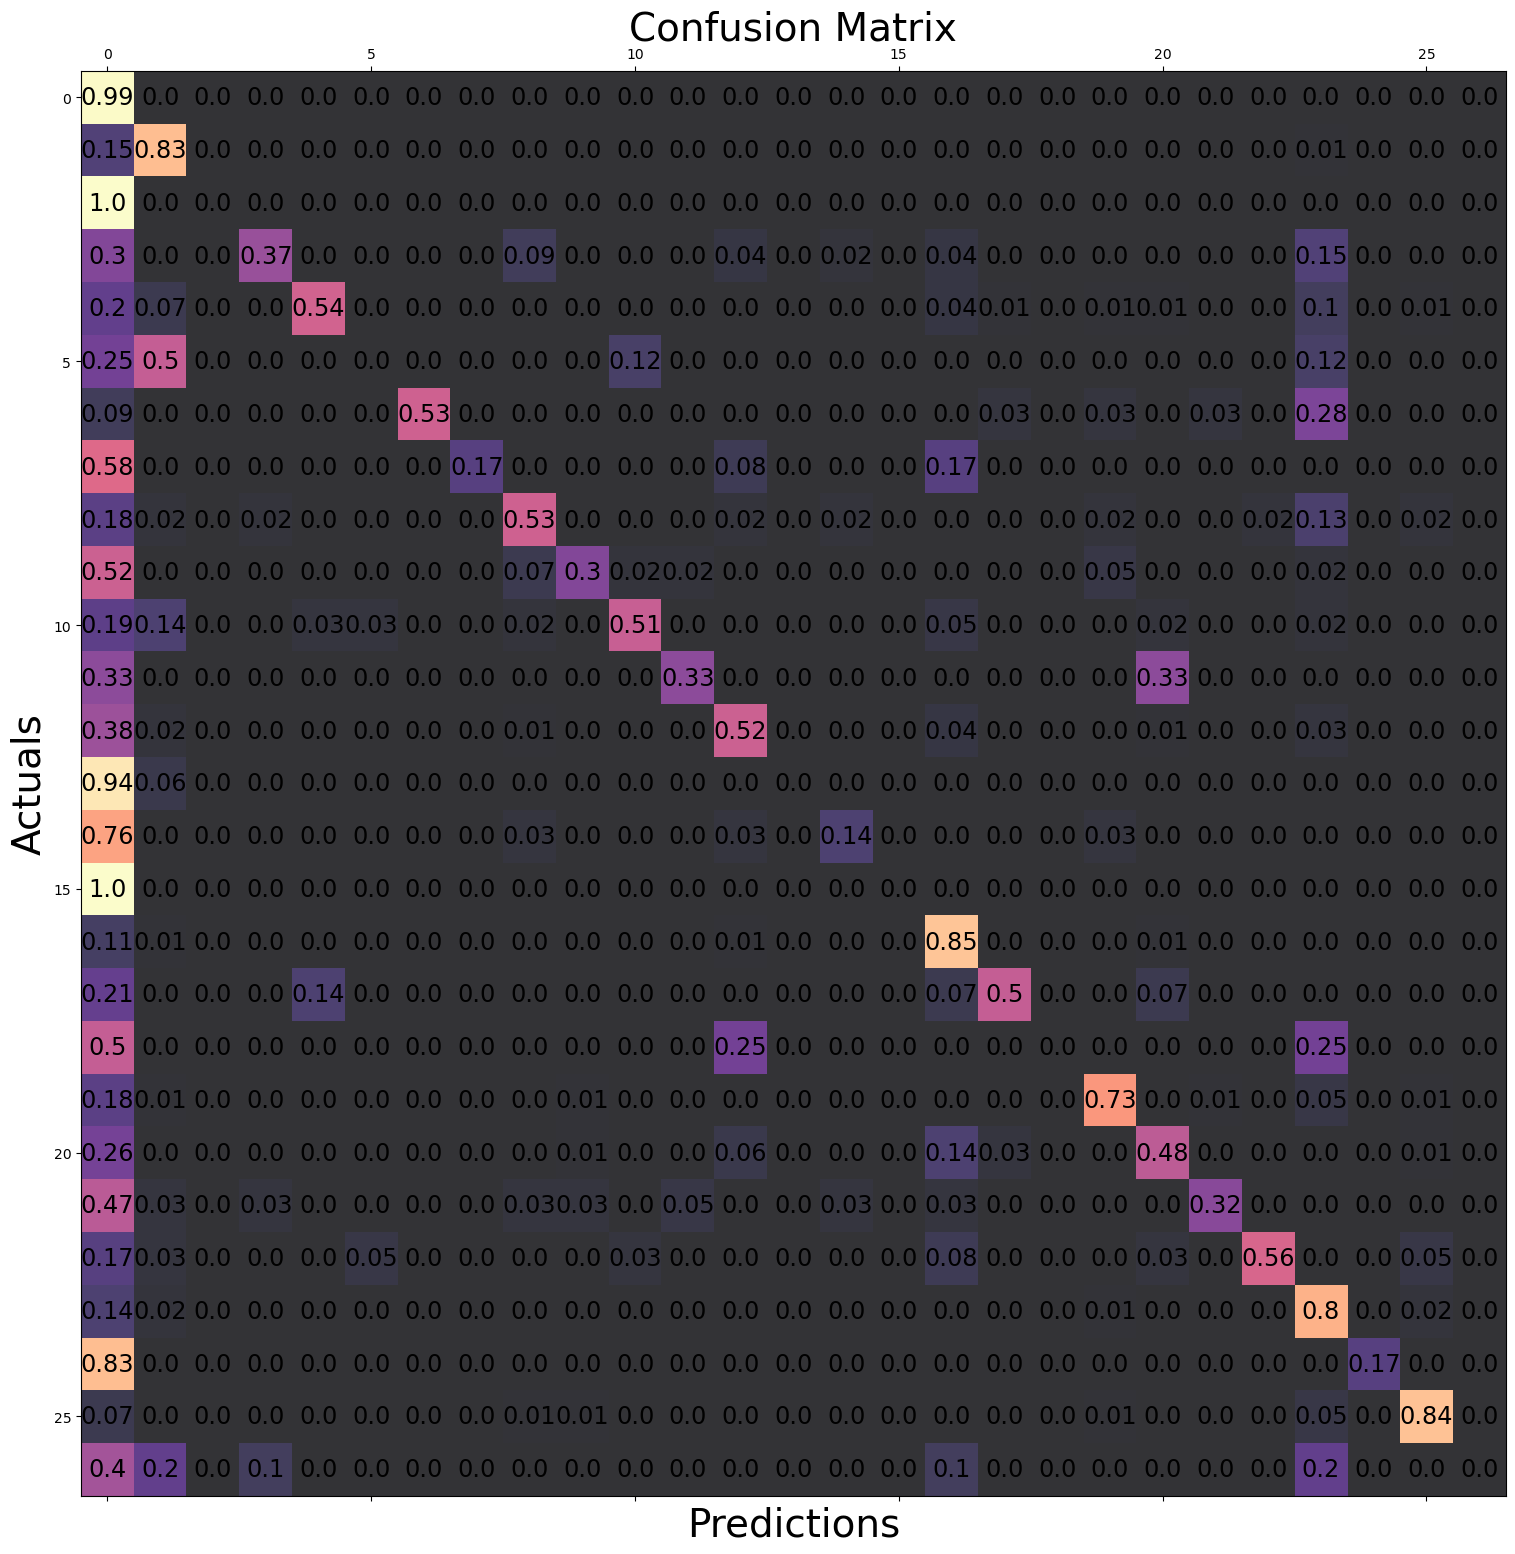

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np   

labels = train_dataset.args_roles[:-1]


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 2)


fig, ax = plt.subplots(figsize=(18.5, 18.5))
ax.matshow(cm_normalized, cmap=plt.cm.magma, alpha=0.8)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
     ax.text(x=j, y=i,s=cm_normalized[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=28)
plt.ylabel('Actuals', fontsize=28)
plt.title('Confusion Matrix', fontsize=28)
plt.show()


## Language Transfert Learning 

### Fine-Tuning over Structural Information over English dataset


#### Loading English Pretrained Model 

In [13]:
#note that parameter EN is only used for tracking on which dataset was/is trained
model = Arg_Classifier(cfg).cuda()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Language constained training

In [14]:
model.set_language_constrains()
#model.freeze_parts()

#### Fine-Tuning

In [15]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from sklearn.metrics import f1_score,confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR
from datetime import datetime



currentDateAndTime = datetime.now()
_id = str(currentDateAndTime.year)+"_"+str(currentDateAndTime.month)+"_"+str(currentDateAndTime.day)+"_"+str(currentDateAndTime.hour)+"_"+str(currentDateAndTime.minute)+"_"+str(currentDateAndTime.second)
_id =  _id +"Language_constained_training"



optimizer = torch.optim.Adam(model.parameters(),lr = 0.00000005)
scheduler = ExponentialLR(optimizer, gamma=0.9)


logSotfMax = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

dataloader_dev = DataLoader(dev_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

mapping = dataloader_train.dataset.args_roles

auto_model.eval()

EPOCHS = 2
patience_counter = 0
patience = 5
max_val_loss = 9999
f1_score_max = 0
output_path = "hw2/stud/saved"
model_name = "model_"+_id+".pth"
PATH = os.path.join(output_path,model_name)


for epoch in range(EPOCHS):

    #TRAINING
    p = []
    g = []
    model.train()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        #print(sample_batched)

        
        optimizer.zero_grad()
       
        #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
        #------------------FILTERING SUB-WORDS----------------------
        subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
        word_emebedding = []
        for i in range(n):
            subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
            flag = subtoken_mask[0,i,0]
            if flag :
                continue
            else :
                word_emebedding.append(subwords_embedding)
        word_emebedding = torch.cat(word_emebedding,dim = 1)
        #-------------------------FORWARD/BACKWARD----------------------------------
        x = model.forward(subwords_embeddings = output_hidden_states_sum,
            perdicate_positional_encoding = sample_batched["positional_encoding"],
            predicate_index = sample_batched["predicate_index"],
            pos_index_encoding = sample_batched["pos_index"],
            predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])        
        b,n = sample_batched["gt"]["arg_gt"].size()
        loss = nll_loss(logSotfMax(x),gt)
        total_loss = total_loss + loss
        #print(loss)
        loss.backward()
        optimizer.step()
    

        counter += 1 
            

        #-------------------------RESULT STORING----------------------------------
        predicted = torch.argmax(x, dim=1).cpu()
        b,n = sample_batched["gt"]["arg_gt"].size()


        p += predicted.tolist()
        g += gt.tolist()
    

    #-------------------------RESULTS----------------------------------
    print("Epochs n.", epoch)
    print("F1 train:",f1_score(g, p, average=None))
    scheduler.step()
    avg_train_loss = total_loss/counter
    writer.add_scalar("Loss/train", avg_train_loss, epoch)



    #EVALUATION
    p = []
    g = []
    model.eval()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_dev):
    
      #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
            #------------------FILTERING SUB-WORDS----------------------
            subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
            word_emebedding = []
            for i in range(n): 
                subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
                flag = subtoken_mask[0,i,0]
                if flag :
                    continue
                else :
                    word_emebedding.append(subwords_embedding)
            word_emebedding = torch.cat(word_emebedding,dim = 1)
            #-------------------------FORWARD----------------------------------
            x = model.forward(subwords_embeddings = output_hidden_states_sum,
                        perdicate_positional_encoding = sample_batched["positional_encoding"],
                        predicate_index = sample_batched["predicate_index"],
                        pos_index_encoding = sample_batched["pos_index"],
                        predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])   


            b,n = sample_batched["gt"]["arg_gt"].size()
            loss = nll_loss(logSotfMax(x),gt)
            total_loss = total_loss + loss
            #-------------------------RESULT STORING----------------------------------
            predicted = torch.argmax(x, dim=1)
            p += predicted.tolist()
            g += gt.tolist()
            counter += 1 
    
    #-------------------------RESULTS----------------------------------

    avg_eval_loss = total_loss/counter

    if avg_eval_loss < max_val_loss:
        max_val_loss = avg_eval_loss
    else :
        patience_counter += 1
    

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    if patience_counter >= patience :  


        print("Early stopping at epoch : ",epoch)
        print("F1 eval :",f1)
        print("F1 eval :",f1_avg)
        break
    else :
        print("EPOCHS :",epoch)
        print("F1 eval :",f1)
        print("F1 eval :",f1_avg)
    

    writer.add_scalar("Loss/validation", avg_eval_loss, epoch)

    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Eval_EN/identification", identification_result["f1"], epoch)
    writer.add_scalar("Eval_EN/classification", classification_result["f1"], epoch)




    if f1_avg > f1_score_max:
        f1_score_max = f1_avg
        torch.save(model.state_dict(),PATH)
    



    





    


Epochs n. 0
F1 train: [0.53881279 0.20895522 0.26126126 0.40471092 0.77188475 0.
 0.05882353 0.31339031 0.38852097 0.         0.         0.99134028
 0.         0.08       0.27906977 0.71949405 0.65554072 0.59300184
 0.         0.355      0.82456605 0.03636364 0.12328767 0.
 0.76847447 0.51584507 0.3943662 ]
EPOCHS : 0
F1 eval : [0.61111111 0.22222222 0.59649123 0.5443787  0.85337471 0.
 0.23529412 0.37333333 0.4494382  0.         0.         0.99286486
 0.         0.2        0.38235294 0.85545723 0.75796178 0.58715596
 0.         0.52631579 0.8325062  0.         0.46666667 0.28571429
 0.80093677 0.62132353 0.64935065]
F1 eval : 0.981594918975923
identification {'true_positives': 4191, 'false_positives': 504, 'false_negatives': 877, 'precision': 0.8926517571884984, 'recall': 0.8269534333070244, 'f1': 0.8585475775888559}
classification_result {'true_positives': 3786, 'false_positives': 909, 'false_negatives': 1282, 'precision': 0.8063897763578275, 'recall': 0.7470402525651144, 'f1': 0.775

### Spanish

#### New Spanish Dataset
bert-base-multilingual-cased


In [17]:
from transformers import BertTokenizer, BertModel
import os
import json
import logging
import torch
from torch.utils.data import DataLoader,Dataset
import random
from typing import Dict



auto_model = AutoModel.from_pretrained("bert-base-multilingual-cased",output_hidden_states=True)
print(f"\nmodel class is      : {type(auto_model)}")

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
print(f"\nmodel class is      : {type(tokenizer)}")


torch.save(auto_model,"hw2/stud/saved/bert_multilingual.pth")


import os
import json
import logging
import torch
from torch.utils.data import DataLoader,Dataset
import random
from typing import Dict

class SRL(Dataset):
 
    def __init__(self,language,tokenizer,path,args_roles = None,pos_list = None,predicate_dis = None) -> None:
        #train
        #self.path_root = 'data'
        #inference 
        self.path_root = 'hw2/stud/data'
        #self.path_root = 'stud/data'
        self.load_data(language,path)
        if args_roles is None :
            self.args_roles,self.list_broken_id = self.list_arg_roles()
            self.args_roles.append("UNK")
        else : 
            self.args_roles = args_roles
            _,self.list_broken_id = self.list_arg_roles()
        

        if pos_list is None :
            self.pos_list,_ = self.list_pos()
            self.pos_list.append("Nothing")
            self.pos_list.append("UNK")
        else : 
            self.pos_list = pos_list
        


        if predicate_dis is None :
            self.predicate_dis,_ = self.list_predicate_roles()
            self.predicate_dis.append("Nothing")
            self.predicate_dis.append("UNK")
        else : 
            self.predicate_dis = predicate_dis
        
        
        


        self.tokenizer = tokenizer

    def load_data(self,language,mode):
        
        mode = mode+".json"
        path = os.path.join(self.path_root,language,mode)
        data_file = open(path)
       
        data_ = json.load(data_file)

        list_data = []

        for data in data_:
            list_data.append(data_[data])
        

        self.data = list_data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, id : int):

        flag = False
        if id in self.list_broken_id :
            flag = True
            while flag == True:

                rand_id = random.randint(0, len(self.data)-1)
                
                if rand_id in self.list_broken_id :
                    pass
                else :
                    flag = False
                    id = rand_id        


        data = self.pre_processing(self.data[id])
        data = self.processig(data)
        return data
        
    def pre_processing(self, data:dict):
        data_list = []
        for role in data["roles"]:
            dictionary = dict()
            dictionary["words"] = data["words"]
            dictionary["role"] = data["roles"][role]
            dictionary["pre_idx"] = role
            dictionary["pos_tags"] = data["pos_tags"]
            dictionary["predicate_meaning"] = data["predicates"]
            data_list.append(dictionary)    
        return data_list
    
    def processig(self,data_list:list):
        
        for dictionary in data_list:

            #dictionary["words"] = data["words"]
            dictionary["gt_arg_identification"] = self.arg_id(dictionary["role"])
            dictionary["gt_arg_classification"] = self.arg_class(dictionary["role"])
            dictionary["pos_idx"] = self.pos_idx(dictionary["pos_tags"])
            dictionary["predicate_meaning_idx"] = self.predicate_meaning_idx(dictionary["predicate_meaning"])
        
        return data_list
   
    def list_arg_roles(self):
        list_roles = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : roles = element["roles"]
            except : flag = False
            if flag :
                for e in roles:
                    sentence = element["roles"][e]

                    for word in sentence:
                        
                        list_roles.append(word)
                list_roles = list(set(list_roles))
            else : 
                list_broken_id.append(i)
        return list_roles,list_broken_id

    def list_predicate_roles(self):
        list_predicate_roles = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : predicates = element["predicates"]
            except : flag = False
            if flag :
                for pre in predicates:
                    list_predicate_roles.append(pre)
                list_predicate_roles = list(set(list_predicate_roles))
            else : 
                list_broken_id.append(i)
        return list_predicate_roles,list_broken_id

    def list_pos(self):
        list_pos = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : pos = element["pos_tags"]
            except : flag = False
            if flag :
                for e in pos:
                    list_pos.append(e)
                list_pos = list(set(list_pos))
            else : 
                list_broken_id.append(i)
        return list_pos,list_broken_id
  
    def arg_class(self,role:list):
        list_idxs = []
        for element in role:
            try : list_idxs.append(self.args_roles.index(element))
            except : list_idxs.append(self.args_roles.index("UNK"))
        

        return torch.tensor(list_idxs, dtype=torch.int64)

    def arg_id(self,role:dict):
        list_idxs = []
        for element in role:
            if element == "_":
                list_idxs.append(0)
            else :
                list_idxs.append(1)

        

        return torch.tensor(list_idxs, dtype=torch.int64)

    def pos_idx(self,pos_tags:dict):
        list_idxs = []
        list_idxs.append(self.pos_list.index("Nothing"))

        for element in pos_tags:
            try :list_idxs.append(self.pos_list.index(element))
            except :list_idxs.append(self.pos_list.index("UNK"))
        
        list_idxs.append(self.pos_list.index("Nothing"))
        return torch.tensor(list_idxs, dtype=torch.int64)
    
    def predicate_meaning_idx(self,predicate_meaning_tags:dict):
        list_idxs = []
        list_idxs.append(self.predicate_dis.index("Nothing"))

        for element in predicate_meaning_tags:
            try : list_idxs.append(self.predicate_dis.index(element))
            except : list_idxs.append(self.predicate_dis.index("UNK"))
            
        
        list_idxs.append(self.predicate_dis.index("Nothing"))
        return torch.tensor(list_idxs, dtype=torch.int64)
   
    def role_gen(self,sentence):

        base = ["_"]*len(sentence["predicates"])
        roles_dict = dict()
        counter = 0
        for i,item in enumerate(sentence["predicates"]):

            if item != "_":
                base = ["_"]*len(sentence["predicates"])
                sentence["roles"] = 10
                roles_dict[str(i)] = base
                counter += 1
        
        if counter == 0:
            sentence["roles"] = { }
            flag = False
            
                
        else :
            sentence["roles"] = roles_dict
            flag = True

        return sentence,flag
        
    def prepare_batch(self,sentence):

        sentence,flag = self.role_gen(sentence)
        
        if flag :

            data = self.pre_processing(sentence)
            data = self.processig(data)
            data = [data]
            
            
            input = dict() 
            gt = dict()
            batch_sentence = [] 
            
            for period in data:
                for sentence in period :

                    
                
                    #print(len(sentence[0]["words"]))
                    pre_idx = int(sentence["pre_idx"])
                    

                    predicate = sentence["words"][pre_idx]

                    text = " ".join(sentence["words"])
                    tokens: list[str] = text.split()
                    predicate: list[str] = predicate.split()

                    #text = sentence[0]["words"]
                    
                    t = (tokens,predicate)

                    batch_sentence.append(t)
                
                
            
        
        

            batch_output = self.tokenizer.batch_encode_plus(batch_sentence,padding=True,is_split_into_words=True, truncation=True,return_offsets_mapping=True, return_tensors="pt")
            


            for period in data:

                list_positional_predicate_encoding = []
                list_predicate_index = [] 
                list_pos_index = [] 
                list_arg_gt = []
                list_predicate_meaning_index = []
                list_meaning_predicate_encoding = []

                for sentence in period:
                    #positional_encoding
                    #+2 per il CLS iniziale ad SEP finale
                    sentence_words_lenght =  len(sentence["words"])
                    positional_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
                    #+1 per il CLS iniziale
                    pre_idx = int(sentence["pre_idx"])
                    positional_predicate_encoding[:,pre_idx+1] = 1
                    list_positional_predicate_encoding.append(positional_predicate_encoding)
                    #print("positional_prefix_encoding",positional_predicate_encoding)
                    list_predicate_index.append(pre_idx)

                    meaning_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
                    pre_idx = int(sentence["pre_idx"])
                    #rather then set the flag 0,1 set with class verb
                    meaning_predicate_encoding[:,pre_idx+1] = sentence["predicate_meaning_idx"][pre_idx+1]
                    list_meaning_predicate_encoding.append(meaning_predicate_encoding)
                    

                    pos = torch.unsqueeze(sentence["pos_idx"],dim = 0)
                    list_pos_index.append(pos)
                    predicate_meaning_idxs = torch.unsqueeze(sentence["predicate_meaning_idx"],dim = 0)
                    list_predicate_meaning_index.append(predicate_meaning_idxs)


                    arg_gt = torch.unsqueeze(sentence["gt_arg_classification"],dim = 0)
                    list_arg_gt.append(arg_gt)


            list_arg_gt = torch.cat(list_arg_gt,dim = 0)
            list_pos_index = torch.cat(list_pos_index,dim = 0)
            list_predicate_meaning_index = torch.cat(list_predicate_meaning_index,dim = 0)
            list_positional_predicate_encoding = torch.cat(list_positional_predicate_encoding,dim = 0)
            list_predicate_meaning_index_bis = torch.cat(list_meaning_predicate_encoding,dim = 0)
            gt["arg_gt"] = list_arg_gt
            input["predicate_index"] = list_predicate_index
            input["pos_index"] = list_pos_index.long()
            input["predicate_meaning_idx"] = list_predicate_meaning_index.long()
            input["predicate_meaning_idx_bis"] = list_predicate_meaning_index_bis.long()
            offset = batch_output.pop("offset_mapping")
            input["BERT_input"] = batch_output
            input["positional_encoding"] = list_positional_predicate_encoding.long()
            input["offset_mapping"] = offset
            input["gt"] = gt
        
        else :
            input = sentence






        return input,flag
    
# here we define our collate function
def collate_fn(batch) -> Dict[str, torch.Tensor]:
    #print(batch)
    input = dict() 
    batch_sentence = [] 
    #print(len(batch))
    for period in batch:
        for sentence in period :
        
            #print(len(sentence[0]["words"]))
            pre_idx = int(sentence["pre_idx"])
            

            predicate = sentence["words"][pre_idx]

            text = " ".join(sentence["words"])
            tokens: list[str] = text.split()
            predicate: list[str] = predicate.split()

            #text = sentence[0]["words"]
            
            t = (tokens,predicate)

            batch_sentence.append(t)
            #print(batch_sentence)

    batch_output = tokenizer.batch_encode_plus(batch_sentence,padding=True,is_split_into_words=True, truncation=True,return_offsets_mapping=True, return_tensors="pt")
    #print(batch_output.keys())


    gt = dict()
    
    


    for period in batch:

        list_positional_predicate_encoding = []
        list_arg_gt = []
        list_predicate_index = [] 
        list_pos_index = [] 
        list_predicate_meaning_index = []
        list_meaning_predicate_encoding = []

        for sentence in period:
            #positional_encoding
            #+2 per il CLS iniziale ad SEP finale
            sentence_words_lenght =  len(sentence["words"])
            positional_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
            #+1 per il CLS iniziale
            pre_idx = int(sentence["pre_idx"])
            positional_predicate_encoding[:,pre_idx+1] = 1
            list_positional_predicate_encoding.append(positional_predicate_encoding)
            #print("positional_prefix_encoding",positional_predicate_encoding)
            list_predicate_index.append(pre_idx)


            meaning_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
            pre_idx = int(sentence["pre_idx"])
            #rather then set the flag 0,1 set with class verb
            meaning_predicate_encoding[:,pre_idx+1] = sentence["predicate_meaning_idx"][pre_idx+1]
            list_meaning_predicate_encoding.append(meaning_predicate_encoding)




            pos = torch.unsqueeze(sentence["pos_idx"],dim = 0)
            list_pos_index.append(pos)
            predicate_meaning_idxs = torch.unsqueeze(sentence["predicate_meaning_idx"],dim = 0)
            list_predicate_meaning_index.append(predicate_meaning_idxs)






            #note CLS and SEP are discharder after Bi-LSTM, the Classifier takes in input only wokrds hidden state embedding
            arg_gt = torch.unsqueeze(sentence["gt_arg_classification"],dim = 0)
            list_arg_gt.append(arg_gt)
        

    list_arg_gt = torch.cat(list_arg_gt,dim = 0)
    list_pos_index = torch.cat(list_pos_index,dim = 0)
    list_predicate_meaning_index = torch.cat(list_predicate_meaning_index,dim = 0)
    list_predicate_meaning_index_bis = torch.cat(list_meaning_predicate_encoding,dim = 0)
    list_positional_predicate_encoding = torch.cat(list_positional_predicate_encoding,dim = 0)
    gt["arg_gt"] = list_arg_gt
    input["predicate_index"] = list_predicate_index
    input["pos_index"] = list_pos_index.long()
    input["predicate_meaning_idx"] = list_predicate_meaning_index.long()
    input["predicate_meaning_idx_bis"] = list_predicate_meaning_index_bis.long()
    offset = batch_output.pop("offset_mapping")
    input["BERT_input"] = batch_output
    input["positional_encoding"] = list_positional_predicate_encoding.long()
    input["offset_mapping"] = offset
    input["gt"] = gt

   


    return input


















Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



model class is      : <class 'transformers.models.bert.modeling_bert.BertModel'>

model class is      : <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


In [18]:

#train_dataset = SRL("EN","train")

#note here we are directly loading args_roles mapping as computed before the the dasetet where we have perfomerd 
#EN and ES dataset should have the same consistency in generating 
train_dataset = SRL("ES",tokenizer,"train",train_dataset.args_roles,train_dataset.pos_list,train_dataset.predicate_dis)
#same mapping should be used in both the dataset
dev_dataset = SRL("ES",tokenizer,"dev",train_dataset.args_roles,train_dataset.pos_list,train_dataset.predicate_dis)

#### English-Spanish attempt

In [20]:
#note that parameter EN is only used for tracking on which dataset was/is trained, and activate loading of the pretrained head
#load the fine-tuned model over english
#path fine tuned
PATH_FINE = "hw2/stud/saved/model_2023_1_5_1_7_37Language_constained_training.pth"
model = Arg_Classifier(cfg)
model.load_state_dict(torch.load(PATH_FINE))
model.train().cuda()


Arg_Classifier(
  (bi_lstm_portable): LSTM(132, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (embedding_predicate_flag): Embedding(2, 32, max_norm=True)
  (embedding_predicate): Embedding(305, 50, max_norm=True)
  (embedding_pos): Embedding(19, 100, max_norm=True)
  (bi_lstm): LSTM(950, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout_language_constraint): Dropout(p=0.6, inplace=False)
  (dropout_in_classifier): Dropout(p=0.4, inplace=False)
  (Relu): ReLU()
  (Sigmoid): Sigmoid()
  (linear0): Linear(in_features=300, out_features=700, bias=True)
  (linear1): Linear(in_features=700, out_features=140, bias=True)
  (linear2): Linear(in_features=140, out_features=28, bias=True)
)

In [21]:
#check that it should be false
print(model.flag_dropout)
model.freeze_parts()

False
Freezed layer : bi_lstm_portable and embedding 


In [22]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from sklearn.metrics import f1_score,confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR
from datetime import datetime



currentDateAndTime = datetime.now()
_id = str(currentDateAndTime.year)+"_"+str(currentDateAndTime.month)+"_"+str(currentDateAndTime.day)+"_"+str(currentDateAndTime.hour)+"_"+str(currentDateAndTime.minute)+"_"+str(currentDateAndTime.second)
_id = _id +"SP"



#optimizer = torch.optim.Adam(model.parameters(),lr = 0.000005)
optimizer = torch.optim.Adam(model.parameters())

scheduler = ExponentialLR(optimizer, gamma=0.9)


logSotfMax = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

dataloader_dev = DataLoader(dev_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

mapping = dataloader_train.dataset.args_roles

auto_model.eval()
auto_model.cuda()

EPOCHS = 200
patience_counter = 0
patience = 3
max_val_loss = 9999
f1_score_max = 0
output_path = "hw2/stud/saved"
model_name = "model_"+_id+".pth"
PATH = os.path.join(output_path,model_name)


for epoch in range(EPOCHS):

    #TRAINING
    p = []
    g = []
    model.train()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        #print(sample_batched)

        
        optimizer.zero_grad()
       
        #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()

        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
        #------------------FILTERING SUB-WORDS----------------------
        subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
        word_emebedding = []
        for i in range(n):
            subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
            flag = subtoken_mask[0,i,0]
            if flag :
                continue
            else :
                word_emebedding.append(subwords_embedding)
        word_emebedding = torch.cat(word_emebedding,dim = 1)
        #-------------------------FORWARD/BACKWARD----------------------------------
        x = model.forward(subwords_embeddings = output_hidden_states_sum,
            perdicate_positional_encoding = sample_batched["positional_encoding"],
            predicate_index = sample_batched["predicate_index"],
            pos_index_encoding = sample_batched["pos_index"],
            predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])        
        b,n = sample_batched["gt"]["arg_gt"].size()
        loss = nll_loss(logSotfMax(x),gt)
        total_loss = total_loss + loss
        #print(loss)
        loss.backward()
        optimizer.step()
    

        counter += 1 
            

        #-------------------------RESULT STORING----------------------------------
        predicted = torch.argmax(x, dim=1)
        p += predicted.tolist()
        g += gt.tolist()
    

    #-------------------------RESULTS----------------------------------
    scheduler.step()

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    print("Epochs n.", epoch)
    print("F1 train:",f1)
    print("F1 avg train:",f1_avg)
    
    avg_train_loss = total_loss/counter
    writer.add_scalar("EN_Loss_ES/train", avg_train_loss, epoch)


    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("EN_Train_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("EN_Train_ES/classification", classification_result["f1"], epoch)



    #EVALUATION
    p = []
    g = []
    model.eval()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_dev):
    
      #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
            #------------------FILTERING SUB-WORDS----------------------
            subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
            word_emebedding = []
            for i in range(n): 
                subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
                flag = subtoken_mask[0,i,0]
                if flag :
                    continue
                else :
                    word_emebedding.append(subwords_embedding)
            word_emebedding = torch.cat(word_emebedding,dim = 1)
            #-------------------------FORWARD----------------------------------
            x = model.forward(subwords_embeddings = output_hidden_states_sum,
                        perdicate_positional_encoding = sample_batched["positional_encoding"],
                        predicate_index = sample_batched["predicate_index"],
                        pos_index_encoding = sample_batched["pos_index"],
                        predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])   


            b,n = sample_batched["gt"]["arg_gt"].size()
            loss = nll_loss(logSotfMax(x),gt)
            total_loss = total_loss + loss
            #-------------------------RESULT STORING----------------------------------
            predicted = torch.argmax(x, dim=1)
            p += predicted.tolist()
            g += gt.tolist()
            counter += 1 
    
    #-------------------------RESULTS----------------------------------
    avg_eval_loss = total_loss/counter

    if avg_eval_loss < max_val_loss:
        max_val_loss = avg_eval_loss
    else :
        patience_counter += 1
    

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    if patience_counter >= patience :  


        print("Early stopping at epoch : ",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
        break
    else :
        print("EPOCHS :",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
    

    writer.add_scalar("EN_Loss_ES/validation", avg_eval_loss, epoch)

    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("EN_Eval_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("EN_Eval_ES/classification", classification_result["f1"], epoch)




    if f1_avg > f1_score_max:
        f1_score_max = f1_avg
        print("SAVED :",PATH)
        cm = confusion_matrix(g, p)
        torch.save(model.state_dict(),PATH)
    

Epochs n. 0
F1 train: [0.         0.         0.         0.03571429 0.34745763 0.
 0.         0.         0.         0.         0.         0.98159913
 0.         0.         0.         0.1375     0.         0.1
 0.         0.         0.31974249 0.         0.         0.47693817
 0.         0.        ]
F1 avg train: 0.9484049003885489
identification {'true_positives': 762, 'false_positives': 227, 'false_negatives': 1395, 'precision': 0.7704752275025278, 'recall': 0.3532684283727399, 'f1': 0.484424666242848}
classification_result {'true_positives': 488, 'false_positives': 501, 'false_negatives': 1669, 'precision': 0.49342770475227504, 'recall': 0.22624014835419565, 'f1': 0.31023521932612846}
EPOCHS : 0
F1 eval : [0.10958904 0.         0.         0.         0.62134387 0.
 0.         0.         0.         0.         0.98570443 0.
 0.         0.         0.0308642  0.         0.         0.
 0.         0.45587583 0.         0.         0.         0.58748595
 0.         0.        ]
F1 avg eval : 0.

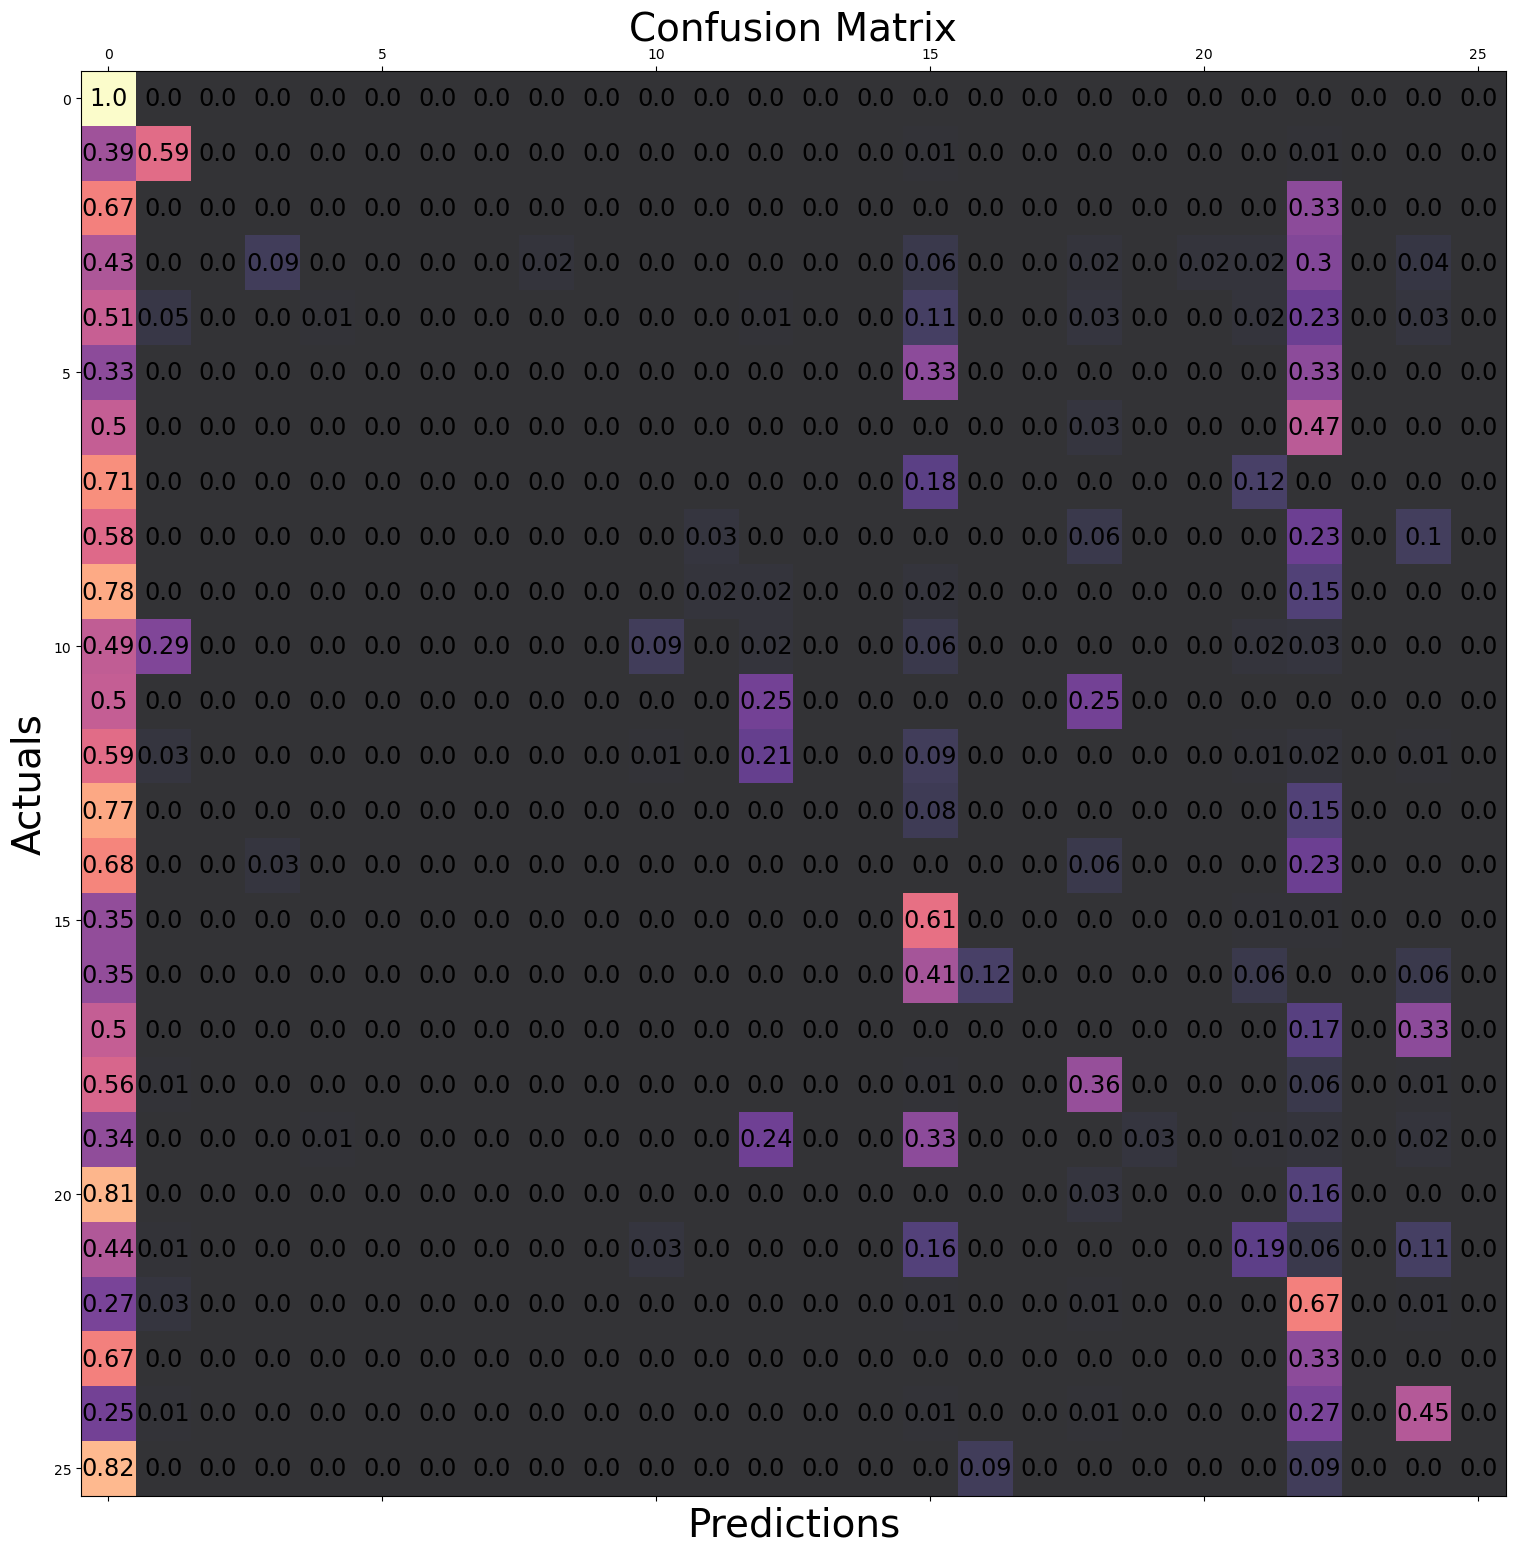

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np   

labels = train_dataset.args_roles[:-1]


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 2)


fig, ax = plt.subplots(figsize=(18.5, 18.5))
ax.matshow(cm_normalized, cmap=plt.cm.magma, alpha=0.8)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
     ax.text(x=j, y=i,s=cm_normalized[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=28)
plt.ylabel('Actuals', fontsize=28)
plt.title('Confusion Matrix', fontsize=28)
plt.show()


#### Compare without Transfert Learning 

In [25]:
model = Arg_Classifier(cfg).cuda()
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from sklearn.metrics import f1_score,confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR
from datetime import datetime



currentDateAndTime = datetime.now()
_id = str(currentDateAndTime.year)+"_"+str(currentDateAndTime.month)+"_"+str(currentDateAndTime.day)+"_"+str(currentDateAndTime.hour)+"_"+str(currentDateAndTime.minute)+"_"+str(currentDateAndTime.second)+"WT"




#optimizer = torch.optim.Adam(model.parameters(),lr = 0.000005)
optimizer = torch.optim.Adam(model.parameters())

scheduler = ExponentialLR(optimizer, gamma=0.9)


logSotfMax = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

dataloader_dev = DataLoader(dev_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

mapping = dataloader_train.dataset.args_roles

auto_model.eval()
auto_model.cuda()

EPOCHS = 200
patience_counter = 0
patience = 3
max_val_loss = 9999
f1_score_max = 0
output_path = "hw2/stud/saved"
model_name = "model_"+_id+".pth"
PATH = os.path.join(output_path,model_name)


for epoch in range(EPOCHS):

    #TRAINING
    p = []
    g = []
    model.train()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        #print(sample_batched)

        
        optimizer.zero_grad()
       
        #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
        #------------------FILTERING SUB-WORDS----------------------
        subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
        word_emebedding = []
        for i in range(n):
            subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
            flag = subtoken_mask[0,i,0]
            if flag :
                continue
            else :
                word_emebedding.append(subwords_embedding)
        word_emebedding = torch.cat(word_emebedding,dim = 1)
        #-------------------------FORWARD/BACKWARD----------------------------------
        x = model.forward(subwords_embeddings = output_hidden_states_sum,
            perdicate_positional_encoding = sample_batched["positional_encoding"],
            predicate_index = sample_batched["predicate_index"],
            pos_index_encoding = sample_batched["pos_index"],
            predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])        
        b,n = sample_batched["gt"]["arg_gt"].size()
        loss = nll_loss(logSotfMax(x),gt)
        total_loss = total_loss + loss
        #print(loss)
        loss.backward()
        optimizer.step()
    

        counter += 1 
            

        #-------------------------RESULT STORING----------------------------------
        predicted = torch.argmax(x, dim=1)
        p += predicted.tolist()
        g += gt.tolist()
    

    #-------------------------RESULTS----------------------------------
    scheduler.step()

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    print("Epochs n.", epoch)
    print("F1 train:",f1)
    print("F1 avg train:",f1_avg)
    
    avg_train_loss = total_loss/counter
    writer.add_scalar("Loss_ES/train", avg_train_loss, epoch)


    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Train_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("Train_ES/classification", classification_result["f1"], epoch)



    #EVALUATION
    p = []
    g = []
    model.eval()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_dev):
    
      #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
            #------------------FILTERING SUB-WORDS----------------------
            subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
            word_emebedding = []
            for i in range(n): 
                subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
                flag = subtoken_mask[0,i,0]
                if flag :
                    continue
                else :
                    word_emebedding.append(subwords_embedding)
            word_emebedding = torch.cat(word_emebedding,dim = 1)
            #-------------------------FORWARD----------------------------------
            x = model.forward(subwords_embeddings = output_hidden_states_sum,
                        perdicate_positional_encoding = sample_batched["positional_encoding"],
                        predicate_index = sample_batched["predicate_index"],
                        pos_index_encoding = sample_batched["pos_index"],
                        predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])   


            b,n = sample_batched["gt"]["arg_gt"].size()
            loss = nll_loss(logSotfMax(x),gt)
            total_loss = total_loss + loss
            #-------------------------RESULT STORING----------------------------------
            predicted = torch.argmax(x, dim=1)
            p += predicted.tolist()
            g += gt.tolist()
            counter += 1 
    
    #-------------------------RESULTS----------------------------------
    avg_eval_loss = total_loss/counter

    if avg_eval_loss < max_val_loss:
        max_val_loss = avg_eval_loss
    else :
        patience_counter += 1
    

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    if patience_counter >= patience :  


        print("Early stopping at epoch : ",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
        break
    else :
        print("EPOCHS :",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
    

    writer.add_scalar("Loss_ES/validation", avg_eval_loss, epoch)

    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Eval_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("Eval_ES/classification", classification_result["f1"], epoch)




    if f1_avg > f1_score_max:
        f1_score_max = f1_avg
        cm = confusion_matrix(g, p)
        #print("SAVED :",PATH)
        #torch.save(model.state_dict(),PATH)
    

Epochs n. 0
F1 train: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.97467111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00903614 0.         0.         0.09861325
 0.         0.        ]
F1 avg train: 0.9298961021435307
identification {'true_positives': 71, 'false_positives': 162, 'false_negatives': 2081, 'precision': 0.30472103004291845, 'recall': 0.032992565055762084, 'f1': 0.05953878406708596}
classification_result {'true_positives': 35, 'false_positives': 198, 'false_negatives': 2117, 'precision': 0.15021459227467812, 'recall': 0.016263940520446097, 'f1': 0.029350104821802933}
EPOCHS : 0
F1 eval : [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.9834971  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.40493515
 0.         0.        ]
F1 avg eval 

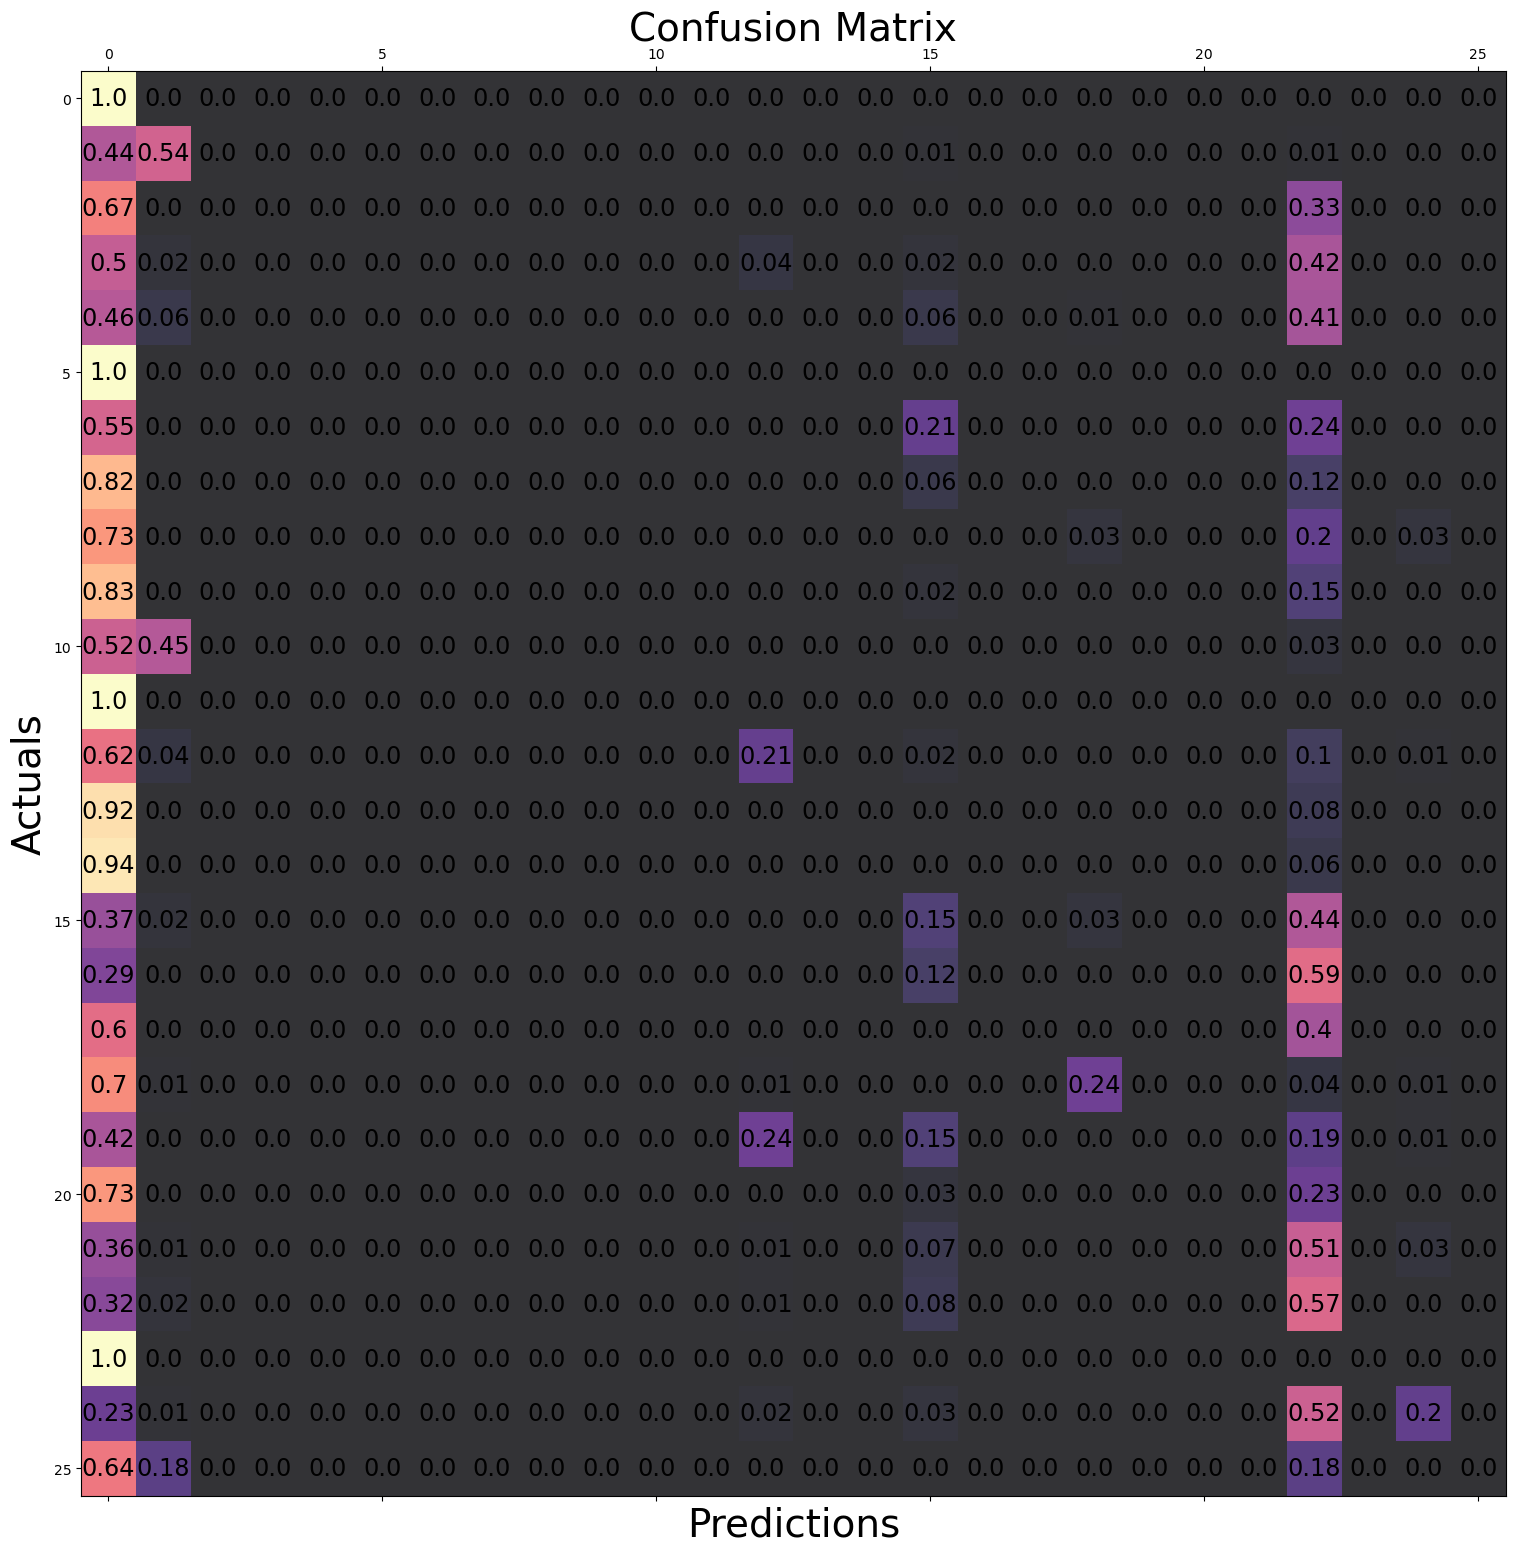

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np   

labels = train_dataset.args_roles[:-1]


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 2)


fig, ax = plt.subplots(figsize=(18.5, 18.5))
ax.matshow(cm_normalized, cmap=plt.cm.magma, alpha=0.8)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
     ax.text(x=j, y=i,s=cm_normalized[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=28)
plt.ylabel('Actuals', fontsize=28)
plt.title('Confusion Matrix', fontsize=28)
plt.show()


### French

#### New French Dataset
bert-base-multilingual-cased


In [27]:
import os
import json
import logging
import torch
from torch.utils.data import DataLoader,Dataset
import random
from typing import Dict

class SRL(Dataset):
 
    def __init__(self,language,tokenizer,path,args_roles = None,pos_list = None,predicate_dis = None) -> None:
        #train
        #self.path_root = 'data'
        #inference 
        self.path_root = 'hw2/stud/data'
        #self.path_root = 'stud/data'
        self.load_data(language,path)
        if args_roles is None :
            self.args_roles,self.list_broken_id = self.list_arg_roles()
            self.args_roles.append("UNK")
        else : 
            self.args_roles = args_roles
            _,self.list_broken_id = self.list_arg_roles()
        

        if pos_list is None :
            self.pos_list,_ = self.list_pos()
            self.pos_list.append("Nothing")
            self.pos_list.append("UNK")
        else : 
            self.pos_list = pos_list
        


        if predicate_dis is None :
            self.predicate_dis,_ = self.list_predicate_roles()
            self.predicate_dis.append("Nothing")
            self.predicate_dis.append("UNK")
        else : 
            self.predicate_dis = predicate_dis
        
        
        


        self.tokenizer = tokenizer

    def load_data(self,language,mode):
        
        mode = mode+".json"
        path = os.path.join(self.path_root,language,mode)
        data_file = open(path)
       
        data_ = json.load(data_file)

        list_data = []

        for data in data_:
            list_data.append(data_[data])
        

        self.data = list_data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, id : int):

        flag = False
        if id in self.list_broken_id :
            flag = True
            while flag == True:

                rand_id = random.randint(0, len(self.data)-1)
                
                if rand_id in self.list_broken_id :
                    pass
                else :
                    flag = False
                    id = rand_id        


        data = self.pre_processing(self.data[id])
        data = self.processig(data)
        return data
        
    def pre_processing(self, data:dict):
        data_list = []
        for role in data["roles"]:
            dictionary = dict()
            dictionary["words"] = data["words"]
            dictionary["role"] = data["roles"][role]
            dictionary["pre_idx"] = role
            dictionary["pos_tags"] = data["pos_tags"]
            dictionary["predicate_meaning"] = data["predicates"]
            data_list.append(dictionary)    
        return data_list
    
    def processig(self,data_list:list):
        
        for dictionary in data_list:

            #dictionary["words"] = data["words"]
            dictionary["gt_arg_identification"] = self.arg_id(dictionary["role"])
            dictionary["gt_arg_classification"] = self.arg_class(dictionary["role"])
            dictionary["pos_idx"] = self.pos_idx(dictionary["pos_tags"])
            dictionary["predicate_meaning_idx"] = self.predicate_meaning_idx(dictionary["predicate_meaning"])
        
        return data_list
   
    def list_arg_roles(self):
        list_roles = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : roles = element["roles"]
            except : flag = False
            if flag :
                for e in roles:
                    sentence = element["roles"][e]

                    for word in sentence:
                        
                        list_roles.append(word)
                list_roles = list(set(list_roles))
            else : 
                list_broken_id.append(i)
        return list_roles,list_broken_id

    def list_predicate_roles(self):
        list_predicate_roles = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : predicates = element["predicates"]
            except : flag = False
            if flag :
                for pre in predicates:
                    list_predicate_roles.append(pre)
                list_predicate_roles = list(set(list_predicate_roles))
            else : 
                list_broken_id.append(i)
        return list_predicate_roles,list_broken_id

    def list_pos(self):
        list_pos = []
        list_broken_id = []
        for i,element in enumerate(self.data):
            flag = True
            try : pos = element["pos_tags"]
            except : flag = False
            if flag :
                for e in pos:
                    list_pos.append(e)
                list_pos = list(set(list_pos))
            else : 
                list_broken_id.append(i)
        return list_pos,list_broken_id
  
    def arg_class(self,role:list):
        list_idxs = []
        for element in role:
            try : list_idxs.append(self.args_roles.index(element))
            except : list_idxs.append(self.args_roles.index("UNK"))
        

        return torch.tensor(list_idxs, dtype=torch.int64)

    def arg_id(self,role:dict):
        list_idxs = []
        for element in role:
            if element == "_":
                list_idxs.append(0)
            else :
                list_idxs.append(1)

        

        return torch.tensor(list_idxs, dtype=torch.int64)

    def pos_idx(self,pos_tags:dict):
        list_idxs = []
        list_idxs.append(self.pos_list.index("Nothing"))

        for element in pos_tags:
            try :list_idxs.append(self.pos_list.index(element))
            except :list_idxs.append(self.pos_list.index("UNK"))
        
        list_idxs.append(self.pos_list.index("Nothing"))
        return torch.tensor(list_idxs, dtype=torch.int64)
    
    def predicate_meaning_idx(self,predicate_meaning_tags:dict):
        list_idxs = []
        list_idxs.append(self.predicate_dis.index("Nothing"))

        for element in predicate_meaning_tags:
            try : list_idxs.append(self.predicate_dis.index(element))
            except : list_idxs.append(self.predicate_dis.index("UNK"))
            
        
        list_idxs.append(self.predicate_dis.index("Nothing"))
        return torch.tensor(list_idxs, dtype=torch.int64)
   
    def role_gen(self,sentence):

        base = ["_"]*len(sentence["predicates"])
        roles_dict = dict()
        counter = 0
        for i,item in enumerate(sentence["predicates"]):

            if item != "_":
                base = ["_"]*len(sentence["predicates"])
                sentence["roles"] = 10
                roles_dict[str(i)] = base
                counter += 1
        
        if counter == 0:
            sentence["roles"] = { }
            flag = False
            
                
        else :
            sentence["roles"] = roles_dict
            flag = True

        return sentence,flag
        
    def prepare_batch(self,sentence):

        sentence,flag = self.role_gen(sentence)
        
        if flag :

            data = self.pre_processing(sentence)
            data = self.processig(data)
            data = [data]
            
            
            input = dict() 
            gt = dict()
            batch_sentence = [] 
            
            for period in data:
                for sentence in period :

                    
                
                    #print(len(sentence[0]["words"]))
                    pre_idx = int(sentence["pre_idx"])
                    

                    predicate = sentence["words"][pre_idx]

                    text = " ".join(sentence["words"])
                    tokens: list[str] = text.split()
                    predicate: list[str] = predicate.split()

                    #text = sentence[0]["words"]
                    
                    t = (tokens,predicate)

                    batch_sentence.append(t)
                
                
            
        
        

            batch_output = self.tokenizer.batch_encode_plus(batch_sentence,padding=True,is_split_into_words=True, truncation=True,return_offsets_mapping=True, return_tensors="pt")
            


            for period in data:

                list_positional_predicate_encoding = []
                list_predicate_index = [] 
                list_pos_index = [] 
                list_arg_gt = []
                list_predicate_meaning_index = []
                list_meaning_predicate_encoding = []

                for sentence in period:
                    #positional_encoding
                    #+2 per il CLS iniziale ad SEP finale
                    sentence_words_lenght =  len(sentence["words"])
                    positional_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
                    #+1 per il CLS iniziale
                    pre_idx = int(sentence["pre_idx"])
                    positional_predicate_encoding[:,pre_idx+1] = 1
                    list_positional_predicate_encoding.append(positional_predicate_encoding)
                    #print("positional_prefix_encoding",positional_predicate_encoding)
                    list_predicate_index.append(pre_idx)

                    meaning_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
                    pre_idx = int(sentence["pre_idx"])
                    #rather then set the flag 0,1 set with class verb
                    meaning_predicate_encoding[:,pre_idx+1] = sentence["predicate_meaning_idx"][pre_idx+1]
                    list_meaning_predicate_encoding.append(meaning_predicate_encoding)
                    

                    pos = torch.unsqueeze(sentence["pos_idx"],dim = 0)
                    list_pos_index.append(pos)
                    predicate_meaning_idxs = torch.unsqueeze(sentence["predicate_meaning_idx"],dim = 0)
                    list_predicate_meaning_index.append(predicate_meaning_idxs)


                    arg_gt = torch.unsqueeze(sentence["gt_arg_classification"],dim = 0)
                    list_arg_gt.append(arg_gt)


            list_arg_gt = torch.cat(list_arg_gt,dim = 0)
            list_pos_index = torch.cat(list_pos_index,dim = 0)
            list_predicate_meaning_index = torch.cat(list_predicate_meaning_index,dim = 0)
            list_positional_predicate_encoding = torch.cat(list_positional_predicate_encoding,dim = 0)
            list_predicate_meaning_index_bis = torch.cat(list_meaning_predicate_encoding,dim = 0)
            gt["arg_gt"] = list_arg_gt
            input["predicate_index"] = list_predicate_index
            input["pos_index"] = list_pos_index.long()
            input["predicate_meaning_idx"] = list_predicate_meaning_index.long()
            input["predicate_meaning_idx_bis"] = list_predicate_meaning_index_bis.long()
            offset = batch_output.pop("offset_mapping")
            input["BERT_input"] = batch_output
            input["positional_encoding"] = list_positional_predicate_encoding.long()
            input["offset_mapping"] = offset
            input["gt"] = gt
        
        else :
            input = sentence






        return input,flag
    
# here we define our collate function
def collate_fn(batch) -> Dict[str, torch.Tensor]:
    #print(batch)
    input = dict() 
    batch_sentence = [] 
    #print(len(batch))
    for period in batch:
        for sentence in period :
        
            #print(len(sentence[0]["words"]))
            pre_idx = int(sentence["pre_idx"])
            

            predicate = sentence["words"][pre_idx]

            text = " ".join(sentence["words"])
            tokens: list[str] = text.split()
            predicate: list[str] = predicate.split()

            #text = sentence[0]["words"]
            
            t = (tokens,predicate)

            batch_sentence.append(t)
            #print(batch_sentence)

    batch_output = tokenizer.batch_encode_plus(batch_sentence,padding=True,is_split_into_words=True, truncation=True,return_offsets_mapping=True, return_tensors="pt")
    #print(batch_output.keys())


    gt = dict()
    
    


    for period in batch:

        list_positional_predicate_encoding = []
        list_arg_gt = []
        list_predicate_index = [] 
        list_pos_index = [] 
        list_predicate_meaning_index = []
        list_meaning_predicate_encoding = []

        for sentence in period:
            #positional_encoding
            #+2 per il CLS iniziale ad SEP finale
            sentence_words_lenght =  len(sentence["words"])
            positional_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
            #+1 per il CLS iniziale
            pre_idx = int(sentence["pre_idx"])
            positional_predicate_encoding[:,pre_idx+1] = 1
            list_positional_predicate_encoding.append(positional_predicate_encoding)
            #print("positional_prefix_encoding",positional_predicate_encoding)
            list_predicate_index.append(pre_idx)


            meaning_predicate_encoding = torch.zeros(1,sentence_words_lenght+2)
            pre_idx = int(sentence["pre_idx"])
            #rather then set the flag 0,1 set with class verb
            meaning_predicate_encoding[:,pre_idx+1] = sentence["predicate_meaning_idx"][pre_idx+1]
            list_meaning_predicate_encoding.append(meaning_predicate_encoding)




            pos = torch.unsqueeze(sentence["pos_idx"],dim = 0)
            list_pos_index.append(pos)
            predicate_meaning_idxs = torch.unsqueeze(sentence["predicate_meaning_idx"],dim = 0)
            list_predicate_meaning_index.append(predicate_meaning_idxs)






            #note CLS and SEP are discharder after Bi-LSTM, the Classifier takes in input only wokrds hidden state embedding
            arg_gt = torch.unsqueeze(sentence["gt_arg_classification"],dim = 0)
            list_arg_gt.append(arg_gt)
        

    list_arg_gt = torch.cat(list_arg_gt,dim = 0)
    list_pos_index = torch.cat(list_pos_index,dim = 0)
    list_predicate_meaning_index = torch.cat(list_predicate_meaning_index,dim = 0)
    list_predicate_meaning_index_bis = torch.cat(list_meaning_predicate_encoding,dim = 0)
    list_positional_predicate_encoding = torch.cat(list_positional_predicate_encoding,dim = 0)
    gt["arg_gt"] = list_arg_gt
    input["predicate_index"] = list_predicate_index
    input["pos_index"] = list_pos_index.long()
    input["predicate_meaning_idx"] = list_predicate_meaning_index.long()
    input["predicate_meaning_idx_bis"] = list_predicate_meaning_index_bis.long()
    offset = batch_output.pop("offset_mapping")
    input["BERT_input"] = batch_output
    input["positional_encoding"] = list_positional_predicate_encoding.long()
    input["offset_mapping"] = offset
    input["gt"] = gt

   


    return input




In [28]:

#train_dataset = SRL("EN","train")

#note here we are directly loading args_roles mapping as computed before the the dasetet where we have perfomerd 
#EN and ES dataset should have the same consistency in generating 
train_dataset = SRL("FR",tokenizer,"train",train_dataset.args_roles,train_dataset.pos_list,train_dataset.predicate_dis)
#same mapping should be used in both the dataset
dev_dataset = SRL("FR",tokenizer,"dev",train_dataset.args_roles,train_dataset.pos_list,train_dataset.predicate_dis)

#### English-French attempt

In [29]:
#note that parameter EN is only used for tracking on which dataset was/is trained, and activate loading of the pretrained head
#load the fine-tuned model over english
model = Arg_Classifier(cfg)
model.load_state_dict(torch.load(PATH_FINE))
model.train().cuda()



Arg_Classifier(
  (bi_lstm_portable): LSTM(132, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (embedding_predicate_flag): Embedding(2, 32, max_norm=True)
  (embedding_predicate): Embedding(305, 50, max_norm=True)
  (embedding_pos): Embedding(19, 100, max_norm=True)
  (bi_lstm): LSTM(950, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout_language_constraint): Dropout(p=0.6, inplace=False)
  (dropout_in_classifier): Dropout(p=0.4, inplace=False)
  (Relu): ReLU()
  (Sigmoid): Sigmoid()
  (linear0): Linear(in_features=300, out_features=700, bias=True)
  (linear1): Linear(in_features=700, out_features=140, bias=True)
  (linear2): Linear(in_features=140, out_features=28, bias=True)
)

#### Language constained training

In [30]:
model.freeze_parts()

Freezed layer : bi_lstm_portable and embedding 


In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from sklearn.metrics import f1_score,confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR
from datetime import datetime
from sklearn.metrics import confusion_matrix



currentDateAndTime = datetime.now()
_id = str(currentDateAndTime.year)+"_"+str(currentDateAndTime.month)+"_"+str(currentDateAndTime.day)+"_"+str(currentDateAndTime.hour)+"_"+str(currentDateAndTime.minute)+"_"+str(currentDateAndTime.second)
_id =  _id +"FR"



#optimizer = torch.optim.Adam(model.parameters(),lr = 0.000005)
optimizer = torch.optim.Adam(model.parameters())

scheduler = ExponentialLR(optimizer, gamma=0.9)


logSotfMax = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

dataloader_dev = DataLoader(dev_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

mapping = dataloader_train.dataset.args_roles

auto_model.eval()
auto_model.cuda()

EPOCHS = 200
patience_counter = 0
patience = 5
max_val_loss = 9999
f1_score_max = 0
output_path = "hw2/stud/saved"
model_name = "model_"+_id+".pth"
PATH = os.path.join(output_path,model_name)


for epoch in range(EPOCHS):

    #TRAINING
    p = []
    g = []
    model.train()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        #print(sample_batched)

        
        optimizer.zero_grad()
       
        #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
        #------------------FILTERING SUB-WORDS----------------------
        subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
        word_emebedding = []
        for i in range(n):
            subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
            flag = subtoken_mask[0,i,0]
            if flag :
                continue
            else :
                word_emebedding.append(subwords_embedding)
        word_emebedding = torch.cat(word_emebedding,dim = 1)
        #-------------------------FORWARD/BACKWARD----------------------------------
        x = model.forward(subwords_embeddings = output_hidden_states_sum,
            perdicate_positional_encoding = sample_batched["positional_encoding"],
            predicate_index = sample_batched["predicate_index"],
            pos_index_encoding = sample_batched["pos_index"],
            predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])        
        b,n = sample_batched["gt"]["arg_gt"].size()
        loss = nll_loss(logSotfMax(x),gt)
        total_loss = total_loss + loss
        #print(loss)
        loss.backward()
        optimizer.step()
    

        counter += 1 
            

        #-------------------------RESULT STORING----------------------------------
        predicted = torch.argmax(x, dim=1)
        p += predicted.tolist()
        g += gt.tolist()
    

    #-------------------------RESULTS----------------------------------
    scheduler.step()

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    print("Epochs n.", epoch)
    print("F1 train:",f1)
    print("F1 avg train:",f1_avg)
    
    avg_train_loss = total_loss/counter
    writer.add_scalar("EN_Loss_ES/train", avg_train_loss, epoch)


    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("EN_Train_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("EN_Train_ES/classification", classification_result["f1"], epoch)



    #EVALUATION
    p = []
    g = []
    model.eval()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_dev):
    
      #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
            #------------------FILTERING SUB-WORDS----------------------
            subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
            word_emebedding = []
            for i in range(n): 
                subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
                flag = subtoken_mask[0,i,0]
                if flag :
                    continue
                else :
                    word_emebedding.append(subwords_embedding)
            word_emebedding = torch.cat(word_emebedding,dim = 1)
            #-------------------------FORWARD----------------------------------
            x = model.forward(subwords_embeddings = output_hidden_states_sum,
                        perdicate_positional_encoding = sample_batched["positional_encoding"],
                        predicate_index = sample_batched["predicate_index"],
                        pos_index_encoding = sample_batched["pos_index"],
                        predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])   


            b,n = sample_batched["gt"]["arg_gt"].size()
            loss = nll_loss(logSotfMax(x),gt)
            total_loss = total_loss + loss
            #-------------------------RESULT STORING----------------------------------
            predicted = torch.argmax(x, dim=1)
            p += predicted.tolist()
            g += gt.tolist()
            counter += 1 
    
    #-------------------------RESULTS----------------------------------
    avg_eval_loss = total_loss/counter

    if avg_eval_loss < max_val_loss:
        max_val_loss = avg_eval_loss
    else :
        patience_counter += 1
    

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    if patience_counter >= patience :  


        print("Early stopping at epoch : ",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
        break
    else :
        print("EPOCHS :",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
    

    writer.add_scalar("EN_Loss_ES/validation", avg_eval_loss, epoch)

    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("EN_Eval_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("EN_Eval_ES/classification", classification_result["f1"], epoch)




    if f1_avg > f1_score_max:
        f1_score_max = f1_avg
        print("SAVED :",PATH)
        cm = confusion_matrix(g, p)
        torch.save(model.state_dict(),PATH)
    

Epochs n. 0
F1 train: [0.04255319 0.         0.         0.03846154 0.33043478 0.
 0.         0.         0.06666667 0.         0.         0.98335219
 0.         0.         0.         0.08633094 0.         0.05128205
 0.         0.         0.39388795 0.         0.         0.
 0.40839695 0.01587302 0.        ]
F1 avg train: 0.9525831914688344
identification {'true_positives': 868, 'false_positives': 250, 'false_negatives': 1413, 'precision': 0.776386404293381, 'recall': 0.38053485313459007, 'f1': 0.5107384524860252}
classification_result {'true_positives': 533, 'false_positives': 585, 'false_negatives': 1748, 'precision': 0.47674418604651164, 'recall': 0.23366944322665498, 'f1': 0.31362165342747866}
EPOCHS : 0
F1 eval : [0.         0.         0.         0.         0.5972093  0.
 0.         0.         0.03636364 0.         0.         0.98675786
 0.         0.         0.         0.02439024 0.08490566 0.
 0.         0.         0.4824356  0.         0.         0.
 0.5152871  0.         0.    

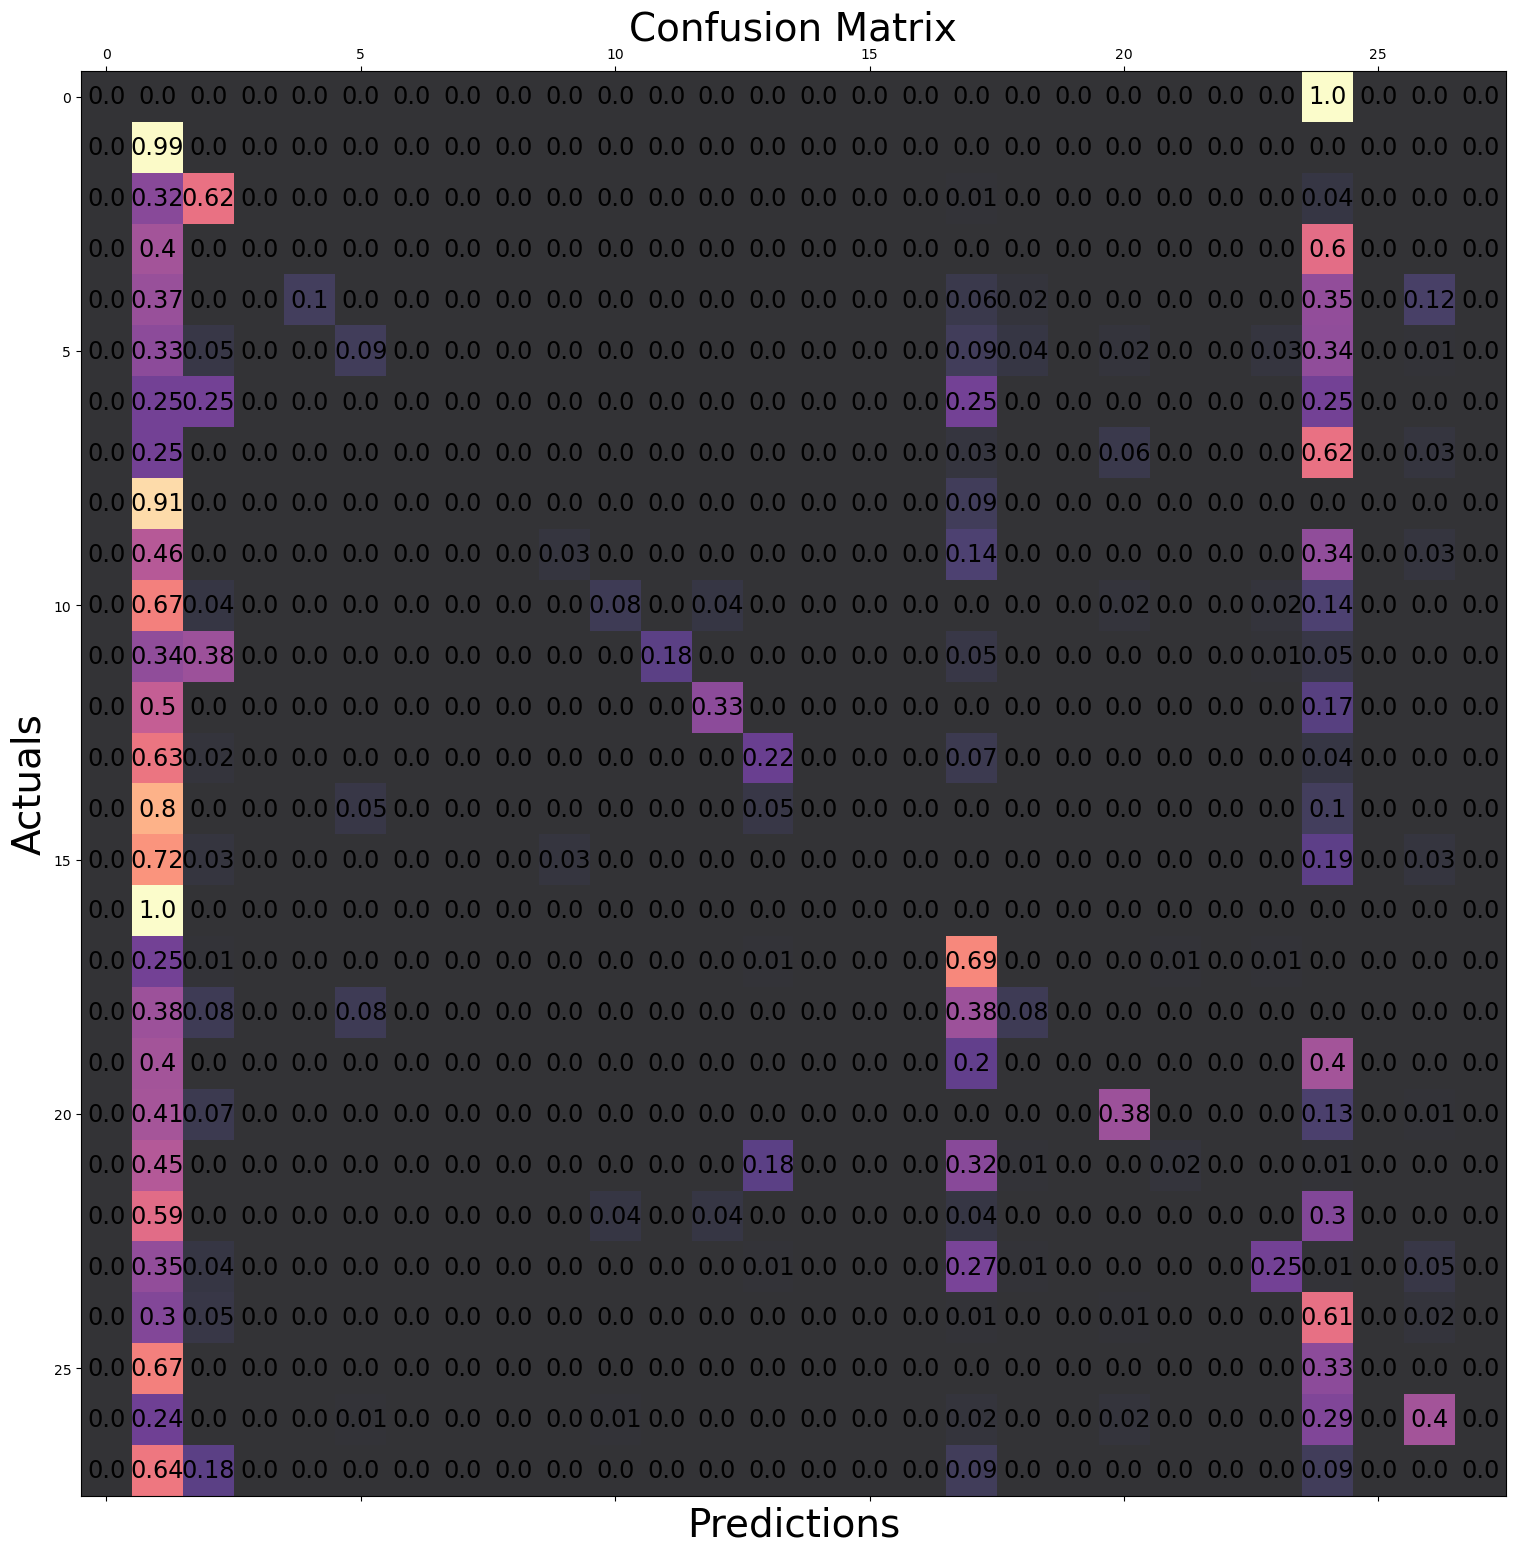

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np   

labels = train_dataset.args_roles[:-1]


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 2)


fig, ax = plt.subplots(figsize=(18.5, 18.5))
ax.matshow(cm_normalized, cmap=plt.cm.magma, alpha=0.8)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
     ax.text(x=j, y=i,s=cm_normalized[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=28)
plt.ylabel('Actuals', fontsize=28)
plt.title('Confusion Matrix', fontsize=28)
plt.show()


#### Compare without Transfert Learning 

In [36]:
model = Arg_Classifier(cfg).cuda()
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from sklearn.metrics import f1_score,confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR
from datetime import datetime


_id = str(currentDateAndTime.year)+"_"+str(currentDateAndTime.month)+"_"+str(currentDateAndTime.day)+"_"+str(currentDateAndTime.hour)+"_"+str(currentDateAndTime.minute)+"_"+str(currentDateAndTime.second)
_id =  _id +"FR"




#optimizer = torch.optim.Adam(model.parameters(),lr = 0.000005)
optimizer = torch.optim.Adam(model.parameters())

scheduler = ExponentialLR(optimizer, gamma=0.9)


logSotfMax = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

dataloader_dev = DataLoader(dev_dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=collate_fn,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

mapping = dataloader_train.dataset.args_roles

auto_model.eval()
auto_model.cuda()

EPOCHS = 200
patience_counter = 0
patience = 5
max_val_loss = 9999
f1_score_max = 0
output_path = "hw2/stud/saved"
model_name = "model_"+_id+".pth"
PATH = os.path.join(output_path,model_name)


for epoch in range(EPOCHS):

    #TRAINING
    p = []
    g = []
    model.train()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        #print(sample_batched)

        
        optimizer.zero_grad()
       
        #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
        #------------------FILTERING SUB-WORDS----------------------
        subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
        word_emebedding = []
        for i in range(n):
            subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
            flag = subtoken_mask[0,i,0]
            if flag :
                continue
            else :
                word_emebedding.append(subwords_embedding)
        word_emebedding = torch.cat(word_emebedding,dim = 1)
        #-------------------------FORWARD/BACKWARD----------------------------------
        x = model.forward(subwords_embeddings = output_hidden_states_sum,
            perdicate_positional_encoding = sample_batched["positional_encoding"],
            predicate_index = sample_batched["predicate_index"],
            pos_index_encoding = sample_batched["pos_index"],
            predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])        
        b,n = sample_batched["gt"]["arg_gt"].size()
        loss = nll_loss(logSotfMax(x),gt)
        total_loss = total_loss + loss
        #print(loss)
        loss.backward()
        optimizer.step()
    

        counter += 1 
            

        #-------------------------RESULT STORING----------------------------------
        predicted = torch.argmax(x, dim=1)
        p += predicted.tolist()
        g += gt.tolist()
    

    #-------------------------RESULTS----------------------------------
    scheduler.step()

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    print("Epochs n.", epoch)
    print("F1 train:",f1)
    print("F1 avg train:",f1_avg)
    
    avg_train_loss = total_loss/counter
    writer.add_scalar("Loss_ES/train", avg_train_loss, epoch)


    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Train_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("Train_ES/classification", classification_result["f1"], epoch)



    #EVALUATION
    p = []
    g = []
    model.eval()
    total_loss = 0
    counter = 0
    for i_batch, sample_batched in enumerate(dataloader_dev):
    
      #----------------------PREPARE INPUT/OUTPUT-------------------------------
        input_bert = sample_batched["BERT_input"]
        input_bert['input_ids'] = input_bert['input_ids'].cuda()
        input_bert['token_type_ids'] = input_bert['token_type_ids'].cuda()
        input_bert['attention_mask'] = input_bert['attention_mask'].cuda()
        sample_batched["positional_encoding"] = sample_batched["positional_encoding"].cuda()
        sample_batched["pos_index"] = sample_batched["pos_index"].cuda()
        #sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx"].cuda()
        sample_batched["predicate_meaning_idx"] = sample_batched["predicate_meaning_idx_bis"].cuda()
        #prepare gt
        gt = torch.flatten(sample_batched["gt"]["arg_gt"]).cuda()
        offset = sample_batched["offset_mapping"]
        #-----------------BERT EMBEDDING---------------------------
        with torch.no_grad():
            output = auto_model(**input_bert)
            output_hidden_states_sum = torch.stack(output.hidden_states[-4:], dim=0).sum(dim=0)
            b,n,h = output_hidden_states_sum.size()
    
            #------------------FILTERING SUB-WORDS----------------------
            subtoken_mask = torch.unsqueeze(offset[:,:, 0] != 0,dim =-1)
            word_emebedding = []
            for i in range(n): 
                subwords_embedding = torch.unsqueeze(output_hidden_states_sum[:,i,:],dim = 1)
                flag = subtoken_mask[0,i,0]
                if flag :
                    continue
                else :
                    word_emebedding.append(subwords_embedding)
            word_emebedding = torch.cat(word_emebedding,dim = 1)
            #-------------------------FORWARD----------------------------------
            x = model.forward(subwords_embeddings = output_hidden_states_sum,
                        perdicate_positional_encoding = sample_batched["positional_encoding"],
                        predicate_index = sample_batched["predicate_index"],
                        pos_index_encoding = sample_batched["pos_index"],
                        predicate_meaning_encoding = sample_batched["predicate_meaning_idx"])   


            b,n = sample_batched["gt"]["arg_gt"].size()
            loss = nll_loss(logSotfMax(x),gt)
            total_loss = total_loss + loss
            #-------------------------RESULT STORING----------------------------------
            predicted = torch.argmax(x, dim=1)
            p += predicted.tolist()
            g += gt.tolist()
            counter += 1 
    
    #-------------------------RESULTS----------------------------------
    avg_eval_loss = total_loss/counter

    if avg_eval_loss < max_val_loss:
        max_val_loss = avg_eval_loss
    else :
        patience_counter += 1
    

    f1 = f1_score(g, p, average=None)
    f1_avg = f1_score(g, p, average="weighted")

    if patience_counter >= patience :  


        print("Early stopping at epoch : ",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
        break
    else :
        print("EPOCHS :",epoch)
        print("F1 eval :",f1)
        print("F1 avg eval :",f1_avg)
    

    writer.add_scalar("Loss_ES/validation", avg_eval_loss, epoch)

    g,p = mapping_args(g,p,mapping)

    identification_result,classification_result = metrics(g,p)
    print("identification",identification_result)
    print("classification_result",classification_result)

    writer.add_scalar("Eval_ES/identification", identification_result["f1"], epoch)
    writer.add_scalar("Eval_ES/classification", classification_result["f1"], epoch)




    if f1_avg > f1_score_max:
        f1_score_max = f1_avg
        cm = confusion_matrix(g, p)
        #print("SAVED :",PATH)
        #torch.save(model.state_dict(),PATH)
    

Epochs n. 0
F1 train: [0.         0.         0.         0.         0.         0.
 0.         0.         0.04855842 0.         0.         0.97637654
 0.         0.07187113 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
F1 avg train: 0.934916274467798
identification {'true_positives': 100, 'false_positives': 200, 'false_negatives': 2176, 'precision': 0.3333333333333333, 'recall': 0.043936731107205626, 'f1': 0.07763975155279504}
classification_result {'true_positives': 45, 'false_positives': 255, 'false_negatives': 2231, 'precision': 0.15, 'recall': 0.01977152899824253, 'f1': 0.03493788819875777}
EPOCHS : 0
F1 eval : [0.         0.         0.         0.         0.         0.
 0.         0.         0.34383954 0.         0.         0.98538109
 0.         0.3673976  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
F1 av

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np   

labels = train_dataset.args_roles[:-1]


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 2)


fig, ax = plt.subplots(figsize=(18.5, 18.5))
ax.matshow(cm_normalized, cmap=plt.cm.magma, alpha=0.8)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
     ax.text(x=j, y=i,s=cm_normalized[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=28)
plt.ylabel('Actuals', fontsize=28)
plt.title('Confusion Matrix', fontsize=28)
plt.show()
